# SASSIE Play 1 Ice Coordinate System Development and Analysis

In [2]:
import cartopy
# import cv2
import cmocean
import cftime
from datetime import datetime, timedelta
import numpy as np
import netCDF4 as nc
import pandas as pd
import pyproj as proj
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.dates as mdates
# import metpy.calc as mpcalc
from scipy import io, interpolate, stats, signal
from scipy.optimize import curve_fit
from scipy.spatial import cKDTree

%matplotlib widget

In [ ]:
# Helping Functions
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    return datetime.fromordinal(int(datenum)) \
           + timedelta(days=days) \
           - timedelta(days=366)

def latlon_to_local(lat, lon, lat_0, lon_0):
    crs_wgs = proj.Proj(init='epsg:4326')  # assuming you're using WGS84 geographic

    #Erect own local flat cartesian coordinate system
    cust = proj.Proj("+proj=aeqd +lat_0={0} +lon_0={1} +datum=WGS84 +units=m".format(lat_0, lon_0))
    x, y = proj.transform(crs_wgs, cust, lon, lat)
    return x, y


def local_to_latlon(x, y, lat_0, lon_0):
    # Define projections
    crs_wgs = proj.Proj(init='epsg:4326')  # WGS84 geographic
    cust = proj.Proj("+proj=aeqd +lat_0={0} +lon_0={1} +datum=WGS84 +units=m".format(lat_0, lon_0))

    # Transform from local AEQD projection back to geographic
    lon, lat = proj.transform(cust, crs_wgs, x, y)
    return lat, lon

def binned_statistics(x, y, bins=10, statistic='median'):
    """
    Bins the x variable into specified intervals, calculates the specified statistic (mean or median)
    of y values within each bin, and returns the statistic values, the bin centers, and the number
    of data points in each bin.

    Parameters:
    - x: array-like, continuous numerical variable to bin
    - y: array-like, continuous numerical variable for which the statistic is calculated within each bin
    - bins: int, the number of bins to create for the x variable
    - statistic: str, 'mean' or 'median' to specify which statistic to calculate

    Returns:
    - bin_centers: array, the center value of each bin
    - statistics: array, the calculated statistic (mean or median) for y values within each bin
    - counts: array, the number of data points in each bin
    """
    
    # Validate the statistic parameter
    if statistic not in ['mean', 'median', 'variance']:
        raise ValueError("Statistic must be 'mean', 'median', or 'variance'.")

    # Create bins
    bin_edges = np.linspace(np.min(x), np.max(x), bins + 1)
    binned_indices = np.digitize(x, bins=bin_edges)

    # Calculate the bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Calculate the specified statistic for each bin
    if statistic == 'mean':
        statistics = [np.nanmean(y[binned_indices == i]) for i in range(1, bins + 1)]
    elif statistic == 'median':
        statistics = [np.nanmedian(y[binned_indices == i]) for i in range(1, bins + 1)]
    elif statistic == 'variance':
        statistics = [np.nanvar(y[binned_indices == i]) for i in range(1, bins + 1)]
    
    # Compute std for each bin
    std_in_bin = [np.nanstd(y[binned_indices == i]) for i in range(1, bins + 1)]

    # Check Normal Distribution Goodness of Fit Test for each bin
    
    # Remove NaN values from the 

    # Count the number of data points for each bin
    counts = [np.sum(binned_indices == i) for i in range(1, bins + 1)]

    return np.array(bin_centers), np.array(statistics), np.array(counts), np.array(std_in_bin)

# Project the drift vectors and wind vectors into the ice coordinate system
def project_vector_to_ice(vx, vy, indices, x_iceedge, y_iceedge):
    """
    Projects a vector into the cross-ice and along-ice directions based on the ice edge orientation.
    
    Parameters:
        vx (array-like): An array of x components of the vector.
        vy (array-like): An array of y components of the vector.
        indices (array-like): Indices of the closest ice edge points.
        ice_x (array-like): An array of x coordinates defining the ice edge.
        ice_y (array-like): An array of y coordinates defining the ice edge.
    
    Returns:
        tuple: (numpy.ndarray of cross-ice components, numpy.ndarray of along-ice components)
    """
    # Compute Along Ice difference
    # Both negative so that positive is in the direction of drift
    along_ice_dx = np.zeros(x_iceedge.size)
    along_ice_dx[:-1] = -np.diff(x_iceedge)
    along_ice_dx[-1] = along_ice_dx[-2]
    along_ice_dy = np.zeros(x_iceedge.size)
    along_ice_dy[:-1] = -np.diff(y_iceedge)
    along_ice_dy[-1] = along_ice_dy[-2]

    # Smooth the computed slope
    fs = 1 / (x_iceedge[1] - x_iceedge[0])
    cutoff = 1/40000
    order = 3
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    along_ice_dy = signal.filtfilt(b, a, along_ice_dy)

    norm = np.sqrt(along_ice_dx**2 + along_ice_dy**2)
    along_ice_dx_norm = along_ice_dx / norm
    along_ice_dy_norm = along_ice_dy / norm

    # Make both negative so positive is into the ice 
    cross_ice_dx_norm = -(-along_ice_dy_norm)
    cross_ice_dy_norm = -(along_ice_dx_norm)
    
    # Get the local unit vectors for each point
    along_x = along_ice_dx_norm[indices]
    along_y = along_ice_dy_norm[indices]
    cross_x = cross_ice_dx_norm[indices]
    cross_y = cross_ice_dy_norm[indices]
    
    # Project the vector components onto the ice edge directions
    cross_ice = vx * cross_x + vy * cross_y
    along_ice = vx * along_x + vy * along_y
    
    return cross_ice, along_ice


In [ ]:
# Add the wave gliders back in
df = pd.read_csv('../data/play1_df.csv')
df = df.dropna(subset=['hs'])
df.head()

# Load the Gridded Ice Maps
ice_map_data = io.loadmat('../data/L1/nws_2022.mat')
ice_map_lat = ice_map_data['LAT']
ice_map_lon = ice_map_data['LON']
ice_map_conc = ice_map_data['iceconc'] * 10
ice_map_datenum = np.squeeze(ice_map_data['date'])
ice_map_date = [datenum_to_datetime(ice_map_datenum[n].astype(np.float64)) for n in range(ice_map_datenum.size)]

# Find index of closest Ice Map - September 10th 
# ind_for_ice_map = 252
ind_for_ice_map = 253
print(ice_map_date[ind_for_ice_map])
ice_concentration = ice_map_conc[:,:,ind_for_ice_map]

# Compute Ice Edge Based on 80% Concentration
ice_conc_80percent = np.zeros(ice_concentration.shape)
ice_conc_80percent[ice_concentration >= 80] = 1

# Compute Ice Edge Based on 15% Concentration
ice_conc_15percent = np.zeros(ice_concentration.shape)
ice_conc_15percent[ice_concentration >= 15] = 1

# Compute Ice Edge Based on 0% Concentration
ice_conc_1percent = np.zeros(ice_concentration.shape)
ice_conc_1percent[ice_concentration >= 1] = 1

# Define the Local Cartesian Coordinate System
lat_0 = 72.48
lon_0 = -151.1

# Convert Lat lon on Ice Map to cartesian system 
x_icemap, y_icemap = latlon_to_local(ice_map_lat, ice_map_lon, lat_0, lon_0)

# Convert the SWIFT Track Coordinates to the local Cartesian system
x_swifts_gliders, y_swifts_gliders = latlon_to_local(df['latitude'], df['longitude'], lat_0, lon_0)

# Get time values for the SWIFTs
time_swifts = df['time'][:]
datetimes = pd.to_datetime(time_swifts)
date_numbers = np.squeeze(mdates.date2num(datetimes))

# Find the x and y location of the 15% ice concentration
# Find the 15% concentration contour line
ice_edge_contour_lon_vals = ice_map_lon[:,0]
lat_vals = ice_map_lat[0,:]

ice_edge_80percent_contour_lat_vals = []
ice_edge_15percent_contour_lat_vals = []
ice_edge_1percent_contour_lat_vals = []

for n in range(ice_conc_15percent.shape[0]):
    # 1% contour
    ice_edge_lat_index_array = np.where(ice_conc_1percent[n,:] == 1)[0]
    if ice_edge_lat_index_array.size > 0:
        ice_edge_1percent_contour_lat_vals.append(lat_vals[ice_edge_lat_index_array[0]])
    else:
        ice_edge_1percent_contour_lat_vals.append(np.NaN)
        
    # 15% contour
    ice_edge_lat_index_array = np.where(ice_conc_15percent[n,:] == 1)[0]
    if ice_edge_lat_index_array.size > 0:
        ice_edge_15percent_contour_lat_vals.append(lat_vals[ice_edge_lat_index_array[0]])
    else:
        ice_edge_15percent_contour_lat_vals.append(np.NaN)

    # 80% contour
    ice_edge_lat_index_array = np.where(ice_conc_80percent[n,:] == 1)[0]
    if ice_edge_lat_index_array.size > 0:
        ice_edge_80percent_contour_lat_vals.append(lat_vals[ice_edge_lat_index_array[0]])
    else:
        ice_edge_80percent_contour_lat_vals.append(np.NaN)

# Convert lon values to numpy array
ice_edge_80percent_contour_lat_vals = np.array(ice_edge_80percent_contour_lat_vals)
ice_edge_15percent_contour_lat_vals = np.array(ice_edge_15percent_contour_lat_vals)
ice_edge_1percent_contour_lat_vals = np.array(ice_edge_1percent_contour_lat_vals)


def smooth_ice_contour(lat_vals, lon_vals, lat_0, lon_0):
    # Convert the ice edge values to cartesian and polar coordinates
    x_iceedge, y_iceedge = latlon_to_local(lat_vals, lon_vals, lat_0, lon_0)

    # Interpolate the x and y ice edge values to make a smooth curve of the ice edge
    x_iceedge_interp = np.linspace(-100000, 200000, num=50000)
    y_iceedge_interp = np.interp(x_iceedge_interp, x_iceedge, y_iceedge)

    fs = 1 / (x_iceedge_interp[1] - x_iceedge_interp[0])
    cutoff = 1/40000
    order = 1
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y_iceedge_smoothed = signal.filtfilt(b, a, y_iceedge_interp)

    return x_iceedge_interp, y_iceedge_smoothed

# Smooth the ice concentration contours
x_80percent_contour, y_80percent_contour = smooth_ice_contour(ice_edge_80percent_contour_lat_vals, ice_edge_contour_lon_vals, lat_0, lon_0)
x_15percent_contour, y_15percent_contour = smooth_ice_contour(ice_edge_15percent_contour_lat_vals, ice_edge_contour_lon_vals, lat_0, lon_0)
x_1percent_contour, y_1percent_contour = smooth_ice_contour(ice_edge_1percent_contour_lat_vals, ice_edge_contour_lon_vals, lat_0, lon_0)


2022-09-11 00:00:00


/opt/homebrew/Caskroom/mambaforge/base/envs/sassie-env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_23550/2657290664.py:18: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = proj.transform(crs_wgs, cust, lon, lat)
/opt/homebrew/Caskroom/mambaforge/base/envs/sassie-env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://p

In [ ]:
print(ice_map_date[252:255])

[datetime.datetime(2022, 9, 10, 0, 0), datetime.datetime(2022, 9, 11, 0, 0), datetime.datetime(2022, 9, 12, 0, 0)]


/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_23550/2992668033.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im2 = ax.pcolormesh(x_icemap, y_icemap, ice_concentration,


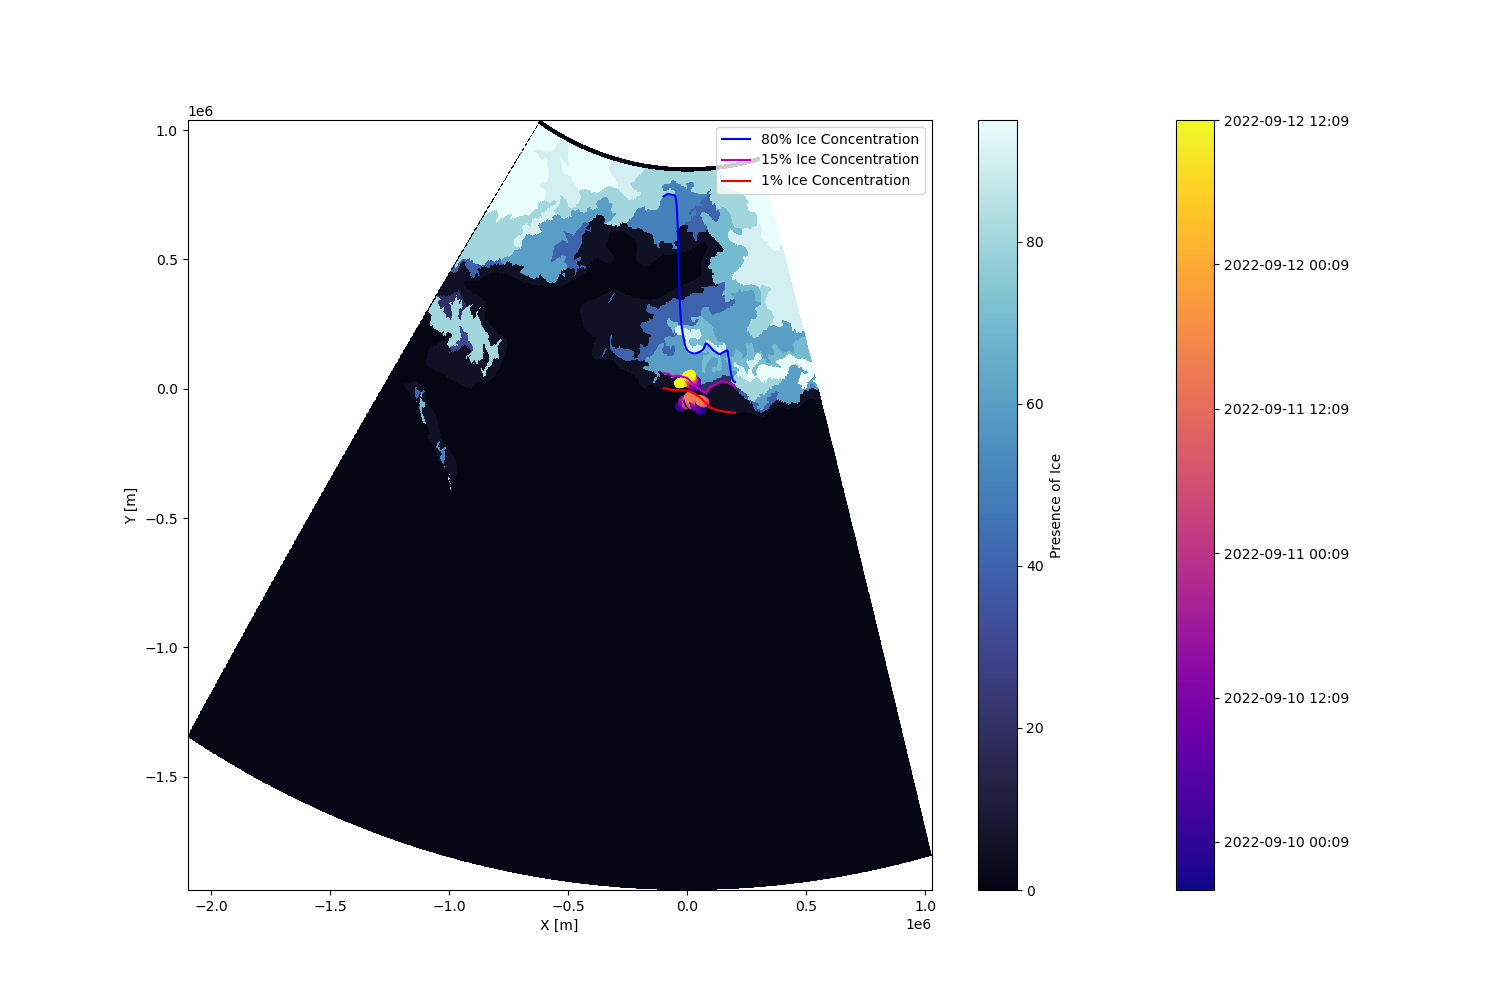

In [ ]:
# Plot the Cartesian System
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(x_80percent_contour, y_80percent_contour, color='b', label='80% Ice Concentration')
ax.plot(x_15percent_contour, y_15percent_contour, color='m', label='15% Ice Concentration')
ax.plot(x_1percent_contour, y_1percent_contour, color='r', label='1% Ice Concentration')
im3 = ax.scatter(x_swifts_gliders, y_swifts_gliders, c=date_numbers, cmap='plasma')
cbar2 = fig.colorbar(im3)
cbar2.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%m'))
# cmap = matplotlib.colors.ListedColormap(['royalblue', 'whitesmoke'])
im2 = ax.pcolormesh(x_icemap, y_icemap, ice_concentration,
                    cmap=cmocean.cm.ice, zorder=0)
cbar = fig.colorbar(im2)
cbar.set_label('Presence of Ice')
# ax.set_xlim(-100000, 200000)
# ax.set_ylim(-120000, 200000)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()

/opt/homebrew/Caskroom/mambaforge/base/envs/sassie-env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_23550/2657290664.py:28: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = proj.transform(cust, crs_wgs, x, y)
/opt/homebrew/Caskroom/mambaforge/base/envs/sassie-env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://p

129.48148753118673
68.32611558326063


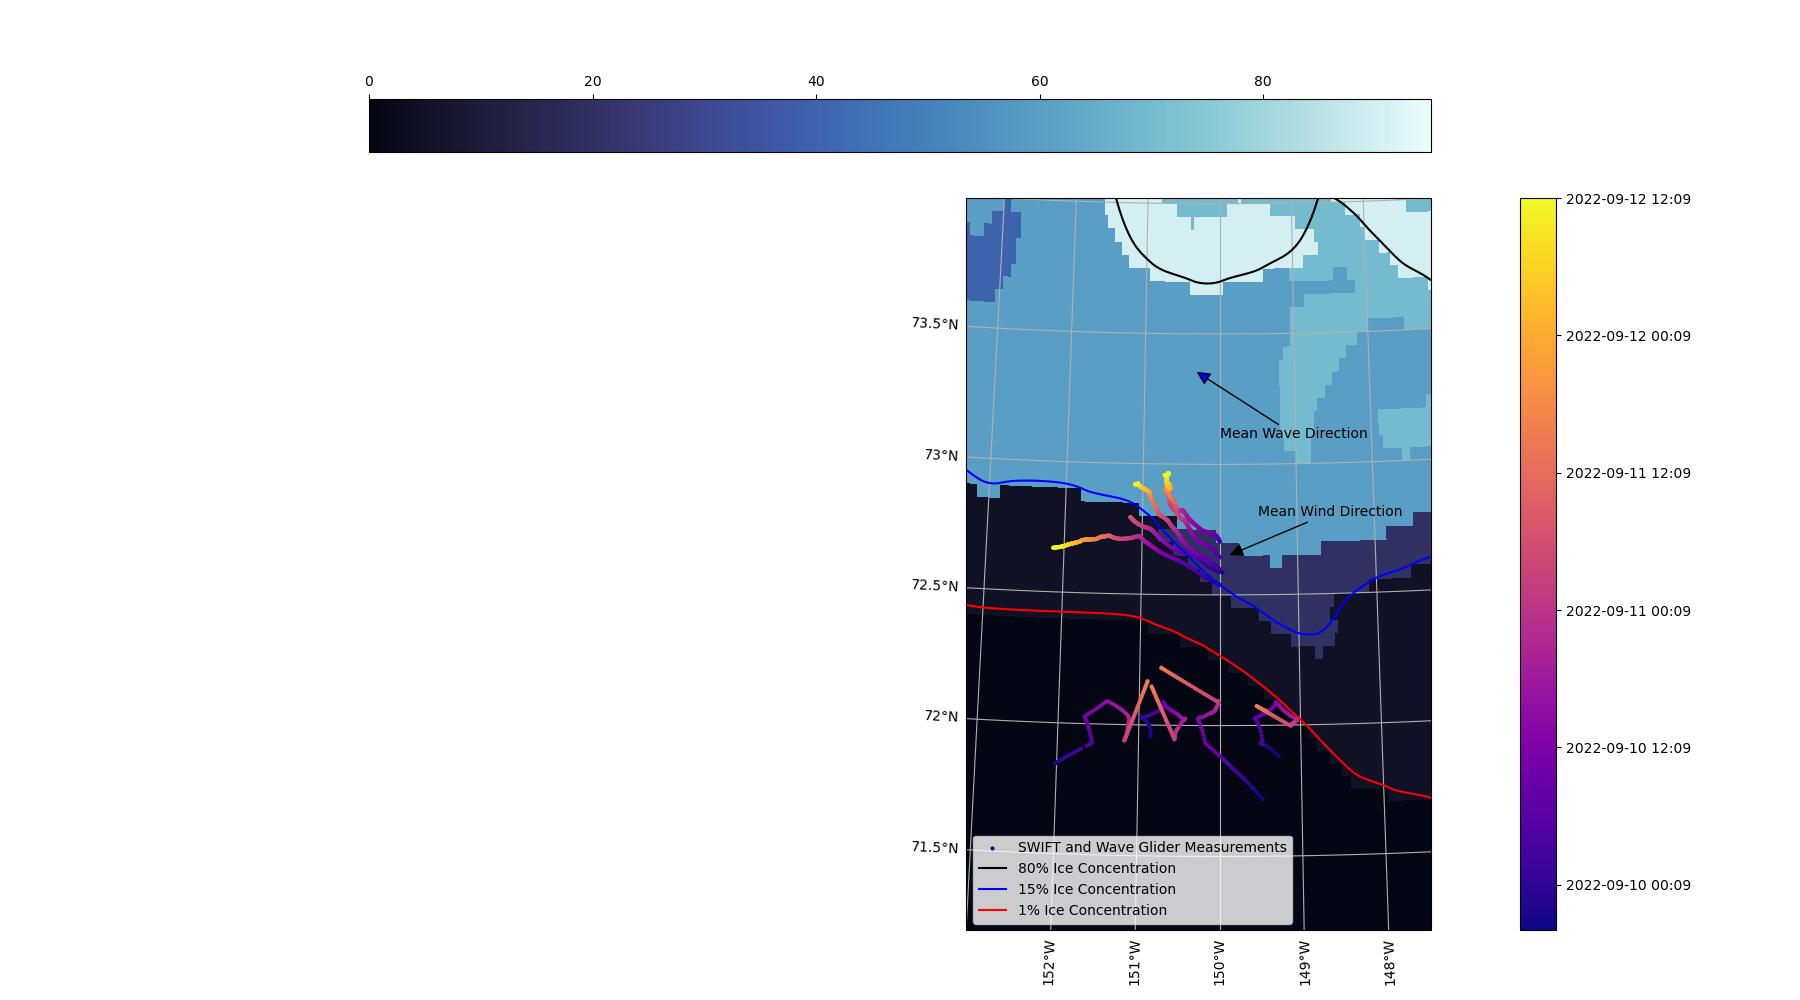

In [ ]:
# Recreate the plot above in lat and lon coordinates as a first paper figure
lat_80percent, lon_80percent = local_to_latlon(x_80percent_contour, y_80percent_contour, lat_0, lon_0)
lat_15percent, lon_15percent = local_to_latlon(x_15percent_contour, y_15percent_contour, lat_0, lon_0)
lat_1percent, lon_1percent = local_to_latlon(x_1percent_contour, y_1percent_contour, lat_0, lon_0)

# Plot the ice map data
CRS = cartopy.crs.NorthPolarStereo(central_longitude=-150)
FIG_SIZE = (18, 10)
EXTENT = [-153, -147.5, 71.2, 74]
OCEAN_COLOR = 'blue'

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
# ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = True
gridlines.right_labels = False

# Plot the mean wave direction
mean_wave_dir = np.mean(df['wave_direction'])
print(mean_wave_dir) # this is in the convention that waves are coming from this direction
ax.annotate("Mean Wave Direction", 
            xy=(-150 + 0.4*np.cos(np.deg2rad(270 - mean_wave_dir)), 73.1 + 0.4*np.sin(np.deg2rad(270 - mean_wave_dir))), 
            xytext=(-150, 73.1), 
            xycoords=cartopy.crs.PlateCarree()._as_mpl_transform(ax),
            arrowprops=dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0, fc='b'))

# Plot the mean wind direction
mean_wind_dir = np.mean(df['winddir'])
print(mean_wind_dir) # Convention that wind is coming from this direction
ax.annotate("Mean Wind Direction", 
            xy=(-149.5 + 0.4*np.cos(np.deg2rad(270 - mean_wind_dir)), 72.8 + 0.4*np.sin(np.deg2rad(270 - mean_wind_dir))), 
            xytext=(-149.5, 72.8), 
            xycoords=cartopy.crs.PlateCarree()._as_mpl_transform(ax),
            arrowprops=dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0, fc='k'))

# Plot the ice map data
im1 = ax.pcolormesh(ice_map_lon, ice_map_lat, ice_concentration,
              transform=cartopy.crs.PlateCarree(), cmap=cmocean.cm.ice, zorder=0)
cbar1 = fig.colorbar(im1, location='top', shrink=0.6)
cbar1.ax.set_label('Ice Concentration [%]')

# # Plot locations of SWIFTs and Wavegliders
im2 = ax.scatter(df['longitude'], df['latitude'], c=date_numbers, cmap='plasma', s=4, transform=cartopy.crs.PlateCarree(), label='SWIFT and Wave Glider Measurements')
cbar = fig.colorbar(im2)
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%m'))
cbar.ax.set_label('Time of Measurement [UTC]')

# Plot Ice Concentration Contours
ax.plot(lon_80percent, lat_80percent, color='k', label='80% Ice Concentration', transform=cartopy.crs.PlateCarree())
ax.plot(lon_15percent, lat_15percent, color='b', label='15% Ice Concentration', transform=cartopy.crs.PlateCarree())
ax.plot(lon_1percent, lat_1percent, color='r', label='1% Ice Concentration', transform=cartopy.crs.PlateCarree())

# Axes properties
ax.set_xlabel('Longitude [Degrees West]')
ax.set_ylabel('Latitude [Degrees North]')
ax.legend(loc='lower left')
plt.tight_layout()

Creating this ice edge has now been saved into to python script that creates a csv file with the local coordinates of the ice edge saved for this x-y coordinate system.

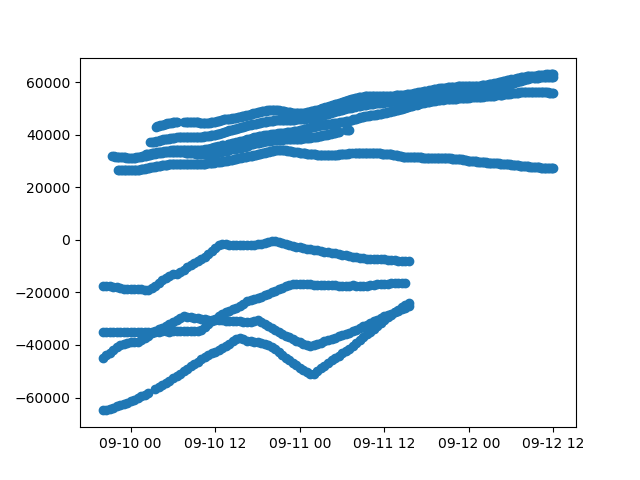

In [ ]:
# Compute the Cross Ice and Along Ice Coordinates for each point
def compute_cross_ice_distance(point_x, point_y, ice_x, ice_y):
    """
    Computes the signed normal (perpendicular) distance of an array of points from the ice edge defined by two arrays of x and y coordinates.
    The distance is negative if the ice edge is above the point (ice_y > point_y).
    
    Parameters:
        point_x (array-like): An array of x coordinates for the points.
        point_y (array-like): An array of y coordinates for the points.
        ice_x (array-like): An array of x coordinates defining the ice edge.
        ice_y (array-like): An array of y coordinates defining the ice edge.
    
    Returns:
        numpy.ndarray: An array of signed distances corresponding to each point.
    """
    points = np.column_stack((point_x, point_y))
    ice_points = np.column_stack((ice_x, ice_y))
    
    # Use KDTree to find the closest point on the ice edge
    tree = cKDTree(ice_points)
    distances, indices = tree.query(points)
    
    # Determine the sign of the distance based on the y-coordinate comparison
    signed_distances = np.where(ice_y[indices] > point_y, -distances, distances)
    
    return signed_distances, indices

cross_ice_distance_initial, indices = compute_cross_ice_distance(x_swifts_gliders, y_swifts_gliders, x_1percent_contour, y_1percent_contour)

fig, ax = plt.subplots()
ax.scatter(datetimes, cross_ice_distance_initial)

/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_23550/2657290664.py:62: RuntimeWarning: Mean of empty slice
  statistics = [np.nanmean(y[binned_indices == i]) for i in range(1, bins + 1)]
/opt/homebrew/Caskroom/mambaforge/base/envs/sassie-env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/Caskroom/mambaforge/base/envs/sassie-env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


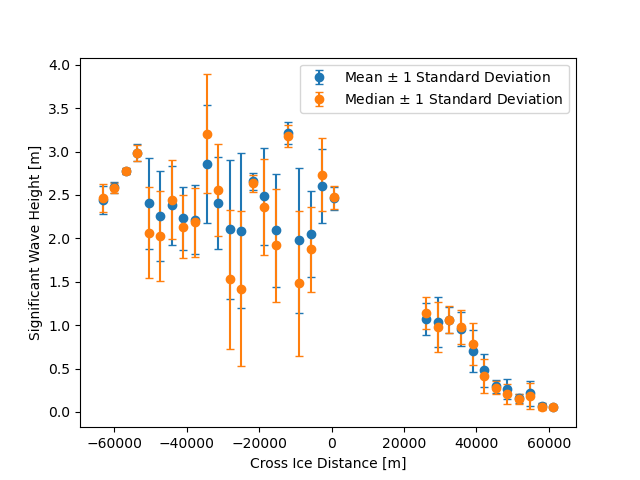

In [ ]:
# Bin the along ice drift v. cross ice distance plot
bin_num = 40
# Note here that the bins are computing correctly but the data includes measurements from the wave gliders which have NaN value
# drift speeds so those bins get NaN value statistics so the number of non NaN bins is different that stated here but 
# it is computing correctly
cross_ice_bin_center, \
significant_wave_height_avg, \
significant_wave_height_bin_count, significant_wave_height_std_in_bin = binned_statistics(cross_ice_distance_initial, 
                                                                                          df['hs'], 
                                                                                          bins=bin_num, statistic='mean')

cross_ice_bin_center, \
significant_wave_height_median, \
significant_wave_height_bin_count, significant_wave_height_std_in_bin = binned_statistics(cross_ice_distance_initial, 
                                                                                          df['hs'], 
                                                                                          bins=bin_num, statistic='median')

fig, ax = plt.subplots()
ax.errorbar(cross_ice_bin_center, significant_wave_height_avg, significant_wave_height_std_in_bin, fmt='o', linestyle='none', 
            capsize=3, label='Mean $\pm$ 1 Standard Deviation')
ax.errorbar(cross_ice_bin_center, significant_wave_height_median, significant_wave_height_std_in_bin, fmt='o', linestyle='none', 
            capsize=3, label='Median $\pm$ 1 Standard Deviation')
ax.set_xlabel('Cross Ice Distance [m]')
ax.set_ylabel('Significant Wave Height [m]')
ax.legend()

2.4406516835293925
6.573565839055222e-05
17867.566451356302


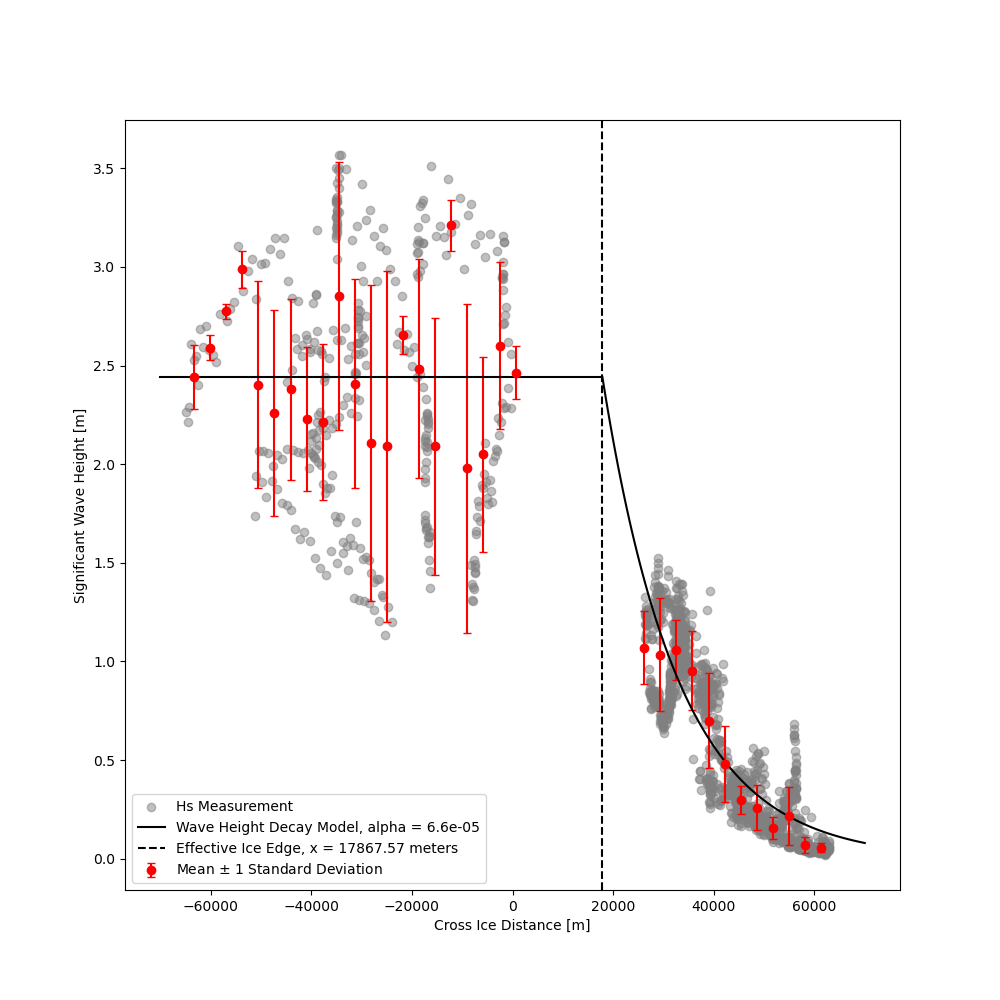

In [ ]:
# Exclude NaN values from the data
inds = ~np.isnan(significant_wave_height_avg)
hs_nonans = significant_wave_height_avg[inds]
cross_ice_bin_center_nonans = cross_ice_bin_center[inds]

# Define constants and initial guesses
out_of_ice_inds = cross_ice_bin_center_nonans < 0
H0 = np.nanmean(hs_nonans[out_of_ice_inds])
initial_guess = [2.9*10**(-3), 20000]

# Define the function to fit the data to
def wave_height_decay_model(x, alpha, horizontal_offset, H0=H0):
    return H0 * np.exp(-alpha * (x - horizontal_offset))

# Fit the exponential decay model for wave height to solve for decay rate and 
x = cross_ice_distance_initial[cross_ice_distance_initial > 0]
y = df['hs'][cross_ice_distance_initial > 0].values
popt, _ = curve_fit(wave_height_decay_model, x, y, p0=initial_guess, nan_policy='omit') 
alpha, horizontal_offset = popt

print(H0)
print(alpha)
print(horizontal_offset)

# Compute a curve for the wave height decay
x_vals = np.linspace(horizontal_offset, 70000, num=100)
wave_decay_curve = wave_height_decay_model(x_vals, alpha, horizontal_offset, H0=H0)

# Plot the regression
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(cross_ice_distance_initial, df['hs'], color='gray', zorder=0, alpha=0.5, label='Hs Measurement')
ax.errorbar(cross_ice_bin_center, significant_wave_height_avg, significant_wave_height_std_in_bin, fmt='o', linestyle='none', 
            capsize=3, label='Mean $\pm$ 1 Standard Deviation', color='r')
ax.plot(x_vals, wave_decay_curve, color='k', label=f'Wave Height Decay Model, alpha = {np.round(alpha, 6)}')
ax.plot([-70000, horizontal_offset], [H0, H0], color='k')
ax.axvline(horizontal_offset, color='k', linestyle='dashed', label=f'Effective Ice Edge, x = {np.round(horizontal_offset, 2)} meters')
ax.set_xlabel('Cross Ice Distance [m]')
ax.set_ylabel('Significant Wave Height [m]')
ax.legend()

/opt/homebrew/Caskroom/mambaforge/base/envs/sassie-env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_23550/2550292822.py:28: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = proj.transform(cust, crs_wgs, x, y)
/opt/homebrew/Caskroom/mambaforge/base/envs/sassie-env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://p

Text(0, 0.5, 'cross ice ekman')

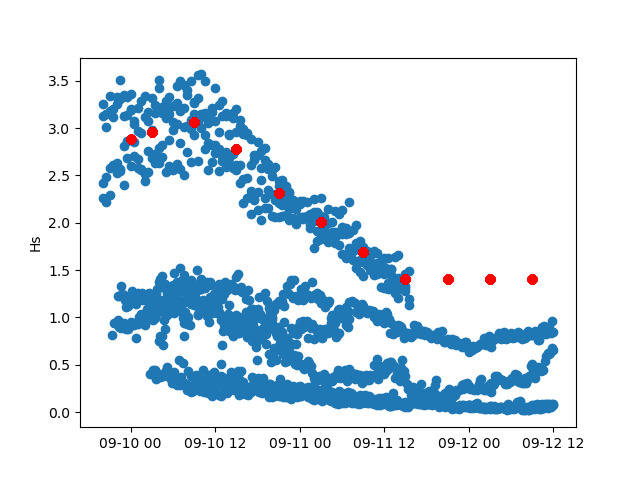

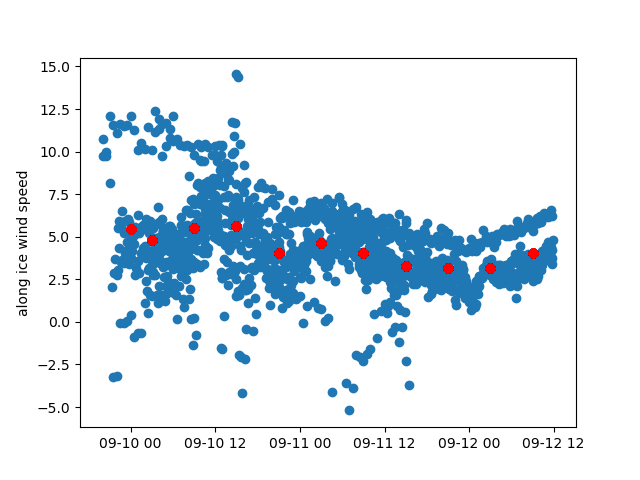

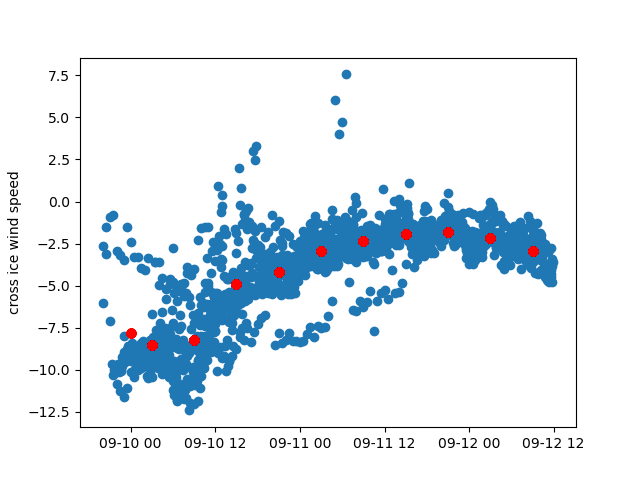

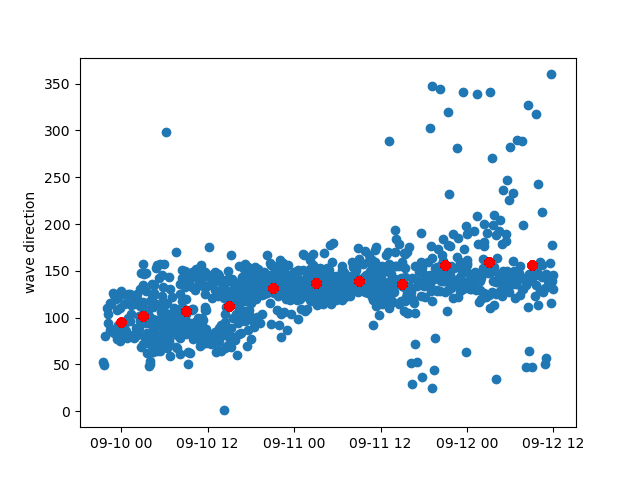

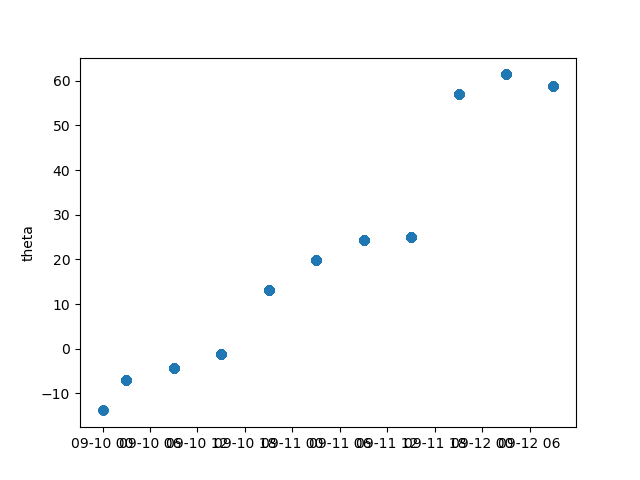

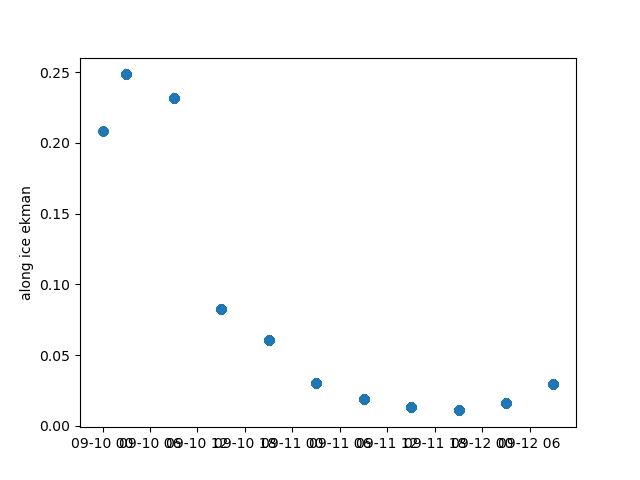

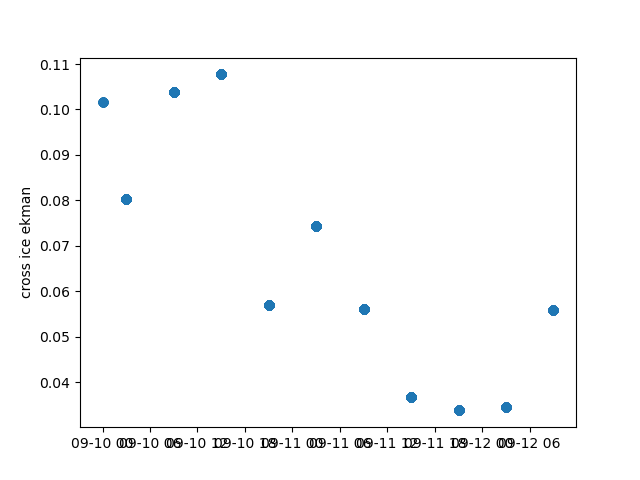

In [ ]:
# Compute an open ocean wave height average every 6 hours and normalize the in ice wave heights by the same
time_window_inds_list = [(df['time'] <= '2022-09-10 00:00:00'), 
                         (df['time'] > '2022-09-10 00:00:00') & (df['time'] <= '2022-09-10 06:00:00'), 
                         (df['time'] > '2022-09-10 06:00:00') & (df['time'] <= '2022-09-10 12:00:00'), 
                         (df['time'] > '2022-09-10 12:00:00') & (df['time'] <= '2022-09-10 18:00:00'), 
                         (df['time'] > '2022-09-10 18:00:00') & (df['time'] <= '2022-09-11 00:00:00'), 
                         (df['time'] > '2022-09-11 00:00:00') & (df['time'] <= '2022-09-11 06:00:00'), 
                         (df['time'] > '2022-09-11 06:00:00') & (df['time'] <= '2022-09-11 12:00:00'),
                         (df['time'] > '2022-09-11 12:00:00') & (df['time'] <= '2022-09-11 18:00:00'),
                         (df['time'] > '2022-09-11 18:00:00') & (df['time'] <= '2022-09-12 00:00:00'),
                         (df['time'] > '2022-09-12 00:00:00') & (df['time'] <= '2022-09-12 06:00:00'),
                         (df['time'] > '2022-09-12 06:00:00') & (df['time'] <= '2022-09-12 12:00:00')]

time_window_centers_list = ['2022-09-10 00:00:00', 
                            '2022-09-10 03:00:00', 
                            '2022-09-10 09:00:00', 
                            '2022-09-10 15:00:00', 
                            '2022-09-10 21:00:00', 
                            '2022-09-11 03:00:00', 
                            '2022-09-11 09:00:00', 
                            '2022-09-11 15:00:00', 
                            '2022-09-11 21:00:00', 
                            '2022-09-12 03:00:00', 
                            '2022-09-12 09:00:00']

# Define the function to fit the data to
def wave_height_decay_model(x, alpha, horizontal_offset):
    return np.exp(-alpha * (x - horizontal_offset))

n = 0

# Create a dataframe to store the adjusted Ice Edges
lat_1percent, lon_1percent = local_to_latlon(x_1percent_contour, y_1percent_contour, lat_0, lon_0)
ice_edge_df = pd.DataFrame(lon_1percent, columns=['lon'])

for inds in time_window_inds_list:
    time_window_df = df[inds]
    if pd.to_datetime(time_window_centers_list[n]) < pd.to_datetime('2022-09-11 21:00:00'):
        H0 = np.nanmean(time_window_df[time_window_df['instrument_type']=='WG']['hs'])
    else:
        H0 = np.unique(df.loc[df['window center']=='2022-09-11 15:00:00', 'H0'])[0]
    
    df.loc[inds, 'H0'] = H0
    df.loc[inds, 'hs norm'] = df.loc[inds, 'hs']/H0
    df.loc[inds&(time_window_df['instrument_type']=='WG'), 'hs norm'] = 1
    df.loc[inds, 'window center'] = time_window_centers_list[n]

    # Fit the Decay model to the data
    # Define constants and initial guesses
    initial_guess = [2.9*10**(-3),30000]

    # Fit the exponential decay model for wave height to solve for decay rate and 
    inds_with_dist = (cross_ice_distance_initial > 0) & inds
    x = cross_ice_distance_initial[inds_with_dist]
    y = df.loc[inds_with_dist, 'hs norm']
    popt, _ = curve_fit(wave_height_decay_model, x, y, p0=initial_guess, nan_policy='omit') 
    alpha, horizontal_offset = popt
    df.loc[inds, 'alpha'] = alpha
    df.loc[inds, 'effective ice edge'] = horizontal_offset
    cross_ice_distance, ice_indices = compute_cross_ice_distance(x_swifts_gliders, y_swifts_gliders, x_1percent_contour, y_1percent_contour + horizontal_offset)
    df.loc[inds, 'cross ice distance'] = cross_ice_distance_initial[inds] - horizontal_offset

    # Compute the New Ice Edge for the given effective ice edge
    lat_vals, _ = local_to_latlon(x_1percent_contour, y_1percent_contour + horizontal_offset, lat_0, lon_0)
    ice_edge_df[time_window_centers_list[n]] = lat_vals

    # Compute the Cross and Along Ice Drift Speeds
    cross_ice_drift_speed, along_ice_drift_speed = project_vector_to_ice(df.loc[inds, 'EW_drift_speed'], df.loc[inds, 'NS_drift_speed'], 
                                                                     ice_indices[inds], x_1percent_contour, y_1percent_contour + horizontal_offset)
    df.loc[inds, 'cross ice drift speed'] = cross_ice_drift_speed
    df.loc[inds, 'along ice drift speed'] = along_ice_drift_speed

    # Compute along and cross ice Wind Speed
    cross_ice_wind_speed, along_ice_wind_speed = project_vector_to_ice(df.loc[inds, 'EW_wind_speed'], df.loc[inds, 'NS_wind_speed'], 
                                                                     ice_indices[inds], x_1percent_contour, y_1percent_contour + horizontal_offset)
    df.loc[inds, 'cross ice wind speed'] = cross_ice_wind_speed
    df.loc[inds, 'cross ice wind speed avg'] = np.nanmean(cross_ice_wind_speed)
    df.loc[inds, 'along ice wind speed'] = along_ice_wind_speed
    df.loc[inds, 'along ice wind speed avg'] = np.nanmean(along_ice_wind_speed)

    # Subtract Direct Windage from along and cross ice drift
    cross_ice_windage = (0.01 * np.nanmean(cross_ice_wind_speed))
    along_ice_windage = (0.01 * np.nanmean(along_ice_wind_speed))
    df.loc[inds, 'cross ice windage'] = cross_ice_windage
    df.loc[inds, 'along ice windage'] = along_ice_windage
    df.loc[inds, 'cross ice drift speed no windage'] = cross_ice_drift_speed - cross_ice_windage
    df.loc[inds, 'along ice drift speed no windage'] = along_ice_drift_speed - along_ice_windage

    # Compute Wind Stress in Each Window
    rho_air = 1.25 # air density, kg/m^3
    C_d_air = 0.00125
    along_ice_wind_stress = rho_air * C_d_air *  np.nanmean(along_ice_wind_speed)**2 * np.sign(np.nanmedian(along_ice_wind_speed))
    df.loc[inds, 'along ice wind stress'] = along_ice_wind_stress
    cross_ice_wind_stress = rho_air * C_d_air *  np.nanmean(cross_ice_wind_speed)**2 * np.sign(np.nanmedian(cross_ice_wind_speed))
    df.loc[inds, 'cross ice wind stress'] = cross_ice_wind_stress

    # Compute the Ekman Transport Estimate
    inertial_period = 12.5 # Hours
    inertial_period_seconds = 12.5 * 3600
    f = 1/inertial_period_seconds
    rho_water = 1025
    D_e = 20 # Effective Slab depth, meters - ma et al 2017
    df.loc[inds, 'along ice ekman'] = -cross_ice_wind_stress / (f * rho_water * D_e)
    df.loc[inds, 'cross ice ekman'] =  along_ice_wind_stress / (f * rho_water * D_e)

    # Average Wave Direction in Each Time Window
    mean_wave_dir = np.nanmean(df.loc[inds, 'wave_direction'])
    df.loc[inds, 'mean wave dir'] = mean_wave_dir

    # Compute Math Convention Wave Angle 
    wave_angle_math_conv = 270 - mean_wave_dir

    # Compute the derivative of this line to get the slope at each point - this are flipped on purpose
    y_iceedge_slope = np.gradient(y_1percent_contour + horizontal_offset, x_1percent_contour)

    # Smooth the derivative
    fs = 1 / (x_1percent_contour[1] - x_1percent_contour[0])
    cutoff = 1/40000
    order = 3
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y_iceedge_slope_smoothed = signal.filtfilt(b, a, y_iceedge_slope)
    
    x_iceedge = x_1percent_contour
    y_iceedge = y_1percent_contour + horizontal_offset

    # Compute Along Ice difference
    # Both negative so that positive is in the direction of drift
    along_ice_dx = np.zeros(x_iceedge.size)
    along_ice_dx[:-1] = -np.diff(x_iceedge)
    along_ice_dx[-1] = along_ice_dx[-2]
    along_ice_dy = np.zeros(x_iceedge.size)
    along_ice_dy[:-1] = -np.diff(y_iceedge)
    along_ice_dy[-1] = along_ice_dy[-2]
    along_ice_dy = signal.filtfilt(b, a, along_ice_dy)

    norm = np.sqrt(along_ice_dx**2 + along_ice_dy**2)
    along_ice_dx_norm = along_ice_dx / norm
    along_ice_dy_norm = along_ice_dy / norm

    # Make both negative so positive is into the ice 
    cross_ice_dx_norm = -(-along_ice_dy_norm)
    cross_ice_dy_norm = -(along_ice_dx_norm)

    # Compute the range for SWIFT measurements
    SWIFT_indices = cross_ice_distance > 0
    min_swift_ice_location = np.min(df.loc[inds, 'x cartesian'])
    max_swift_ice_location = np.max(df.loc[inds, 'x cartesian'])

    # Compute the angle of each ice edge vector
    along_ice_edge_angle_rad = np.abs(np.arctan2(along_ice_dy_norm, along_ice_dx_norm))
    along_ice_edge_angle_deg = np.rad2deg(along_ice_edge_angle_rad)

    # Compute the angle between the mean wave direction and the ice edge at every point
    incidence_angle_deg = along_ice_edge_angle_deg - wave_angle_math_conv

    # Compute the average incidence angle that the SWIFTs encounter
    swift_range_inds = (x_iceedge > min_swift_ice_location) & (x_iceedge < max_swift_ice_location)
    incidence_angle_deg_avg = np.nanmean(incidence_angle_deg[swift_range_inds])
    incidence_angle_deg_min = np.min(incidence_angle_deg[swift_range_inds])
    incidence_angle_deg_max = np.max(incidence_angle_deg[swift_range_inds])
    incidence_angle_rad_avg = np.deg2rad(incidence_angle_deg_avg)
    incidence_angle_rad_min = np.deg2rad(incidence_angle_deg_min)
    incidence_angle_rad_max = np.deg2rad(incidence_angle_deg_max)

    # average and minimum incident angles to df
    df.loc[inds, 'theta0 avg [deg]'] = incidence_angle_deg_avg
    df.loc[inds, 'theta0 avg [rad]'] = incidence_angle_rad_avg 



    # Increment up for the next window
    n += 1

# Save the Ice Edges as a csv
ice_edge_df.to_csv('../data/ice_edge_df.csv')

fig, ax = plt.subplots()
ax.scatter(pd.to_datetime(df['time']), df['hs'])
ax.scatter(pd.to_datetime(df['window center']), df['H0'], color='r')
ax.set_ylabel('Hs')

fig, ax = plt.subplots()
ax.scatter(pd.to_datetime(df['time']), df['along ice wind speed'])
ax.scatter(pd.to_datetime(df['window center']), df['along ice wind speed avg'], color='r')
ax.set_ylabel('along ice wind speed')

fig, ax = plt.subplots()
ax.scatter(pd.to_datetime(df['time']), df['cross ice wind speed'])
ax.scatter(pd.to_datetime(df['window center']), df['cross ice wind speed avg'], color='r')
ax.set_ylabel('cross ice wind speed')

fig, ax = plt.subplots()
ax.scatter(pd.to_datetime(df['time']), df['wave_direction'])
ax.scatter(pd.to_datetime(df['window center']), df['mean wave dir'], color='r')
ax.set_ylabel('wave direction')

fig, ax = plt.subplots()
ax.scatter(pd.to_datetime(df['window center']), df['theta0 avg [deg]'])
ax.set_ylabel('theta')

fig, ax = plt.subplots()
ax.scatter(pd.to_datetime(df['window center']), df['along ice ekman'])
ax.set_ylabel('along ice ekman')

fig, ax = plt.subplots()
ax.scatter(pd.to_datetime(df['window center']), df['cross ice ekman'])
ax.set_ylabel('cross ice ekman')



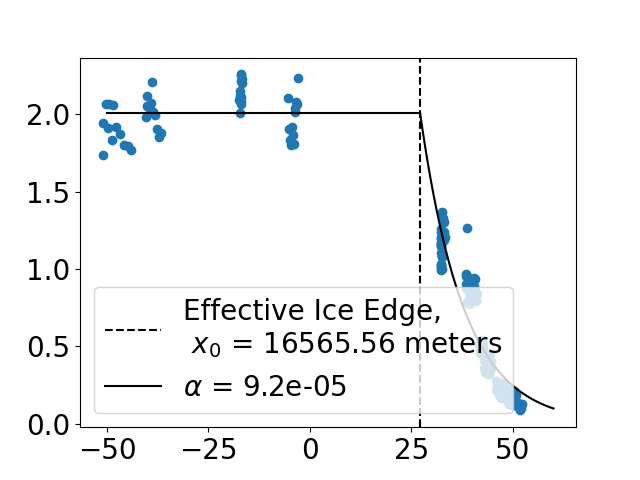

In [ ]:
# Example Time Window Fit
inds = time_window_inds_list[5] 


fig, ax = plt.subplots()
ax.scatter(cross_ice_distance_initial[inds]/1000, df.loc[inds, 'hs'])
H0 = np.unique(df.loc[inds, 'H0'])[0]
ax.plot([-50000/1000, np.unique(df.loc[inds, 'effective ice edge'])[0]/1000], [H0, H0], color='k')
ax.axvline(np.unique(df.loc[inds, 'effective ice edge'])[0]/1000, color='k', linestyle='dashed', label=f'Effective Ice Edge, \n $x_0$ = {np.round(horizontal_offset, 2)} meters')
alpha = np.unique(df.loc[inds, 'alpha'])[0]
x0 = np.unique(df.loc[inds, 'effective ice edge'])[0]
ax.plot(np.linspace(x0/1000, 60), H0 * np.exp(-alpha * (np.linspace(x0, 60000) - x0)), color='k', label=f'$\\alpha$ = {np.round(alpha, 6)}')
# ax.set_xlabel('Distance from Ice Edge, $\\Delta x$ [km]')
# ax.set_ylabel('Significant Wave Height [m]')
ax.legend(fontsize=20, loc='lower left')
ax.tick_params(axis='both', labelsize=20)

7.942141868964156e-05


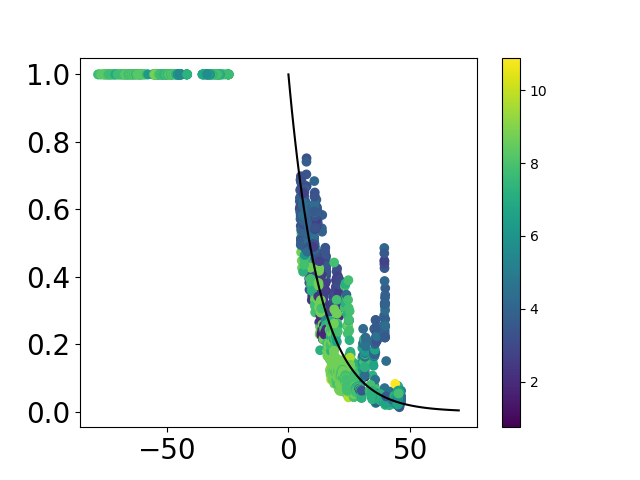

In [ ]:
# Plot the Normlaized Wave Heights
average_alpha = np.mean(df['alpha'])
print(average_alpha)

fig, ax = plt.subplots()
im = ax.scatter(df['cross ice distance']/1000, df['hs norm'], c=df['wave_period'])
cbar = plt.colorbar(im)
# cbar.set_label('Peak Wave Period [s]')
ax.plot(np.linspace(0, 70000, num=100)/1000, np.exp(-average_alpha * np.linspace(0, 70000, num=100)), color='k')
ax.tick_params(axis='both', labelsize=20)




Text(0, 0.5, 'Significant Wave Height [m]')

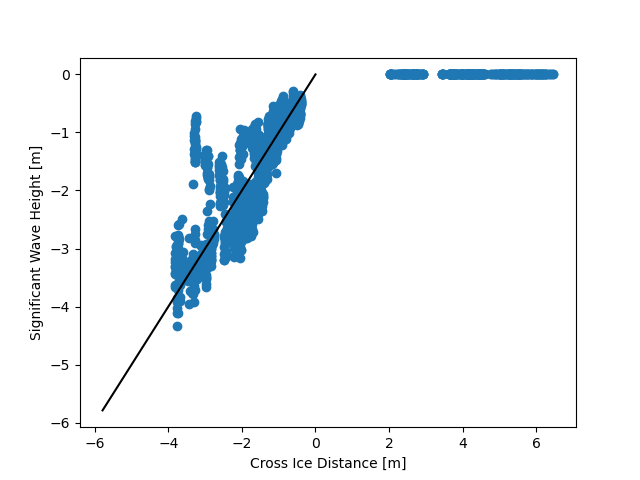

In [ ]:
# Plot the Normlaized Wave Heights
fig, ax = plt.subplots()
im = ax.scatter(-(8.27*10**(-5)) * df['cross ice distance'], np.log(df['hs norm']))
# cbar = plt.colorbar(im)
ax.plot(-(8.27*10**(-5)) * np.linspace(0, 70000, num=100), np.log(np.exp(-(8.27*10**(-5)) * np.linspace(0, 70000, num=100))), color='k')
# ax.plot([-70000, horizontal_offset], [1, 1], color='k')
# ax.axvline(horizontal_offset, color='k', linestyle='dashed', label=f'Effective Ice Edge, x = {np.round(horizontal_offset, 2)} meters')
ax.set_xlabel('Cross Ice Distance [m]')
ax.set_ylabel('Significant Wave Height [m]')
# ax.legend()

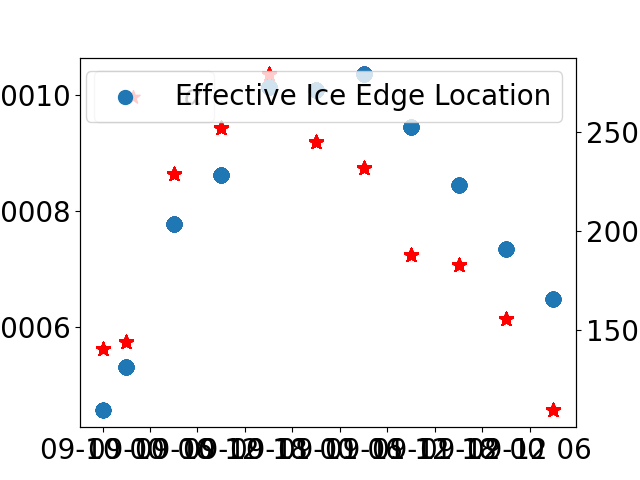

In [ ]:
fig, ax = plt.subplots()
ax.scatter(pd.to_datetime(df['window center']), df['alpha'], label='$\\alpha$', marker='*', color='r', s=100)
# ax.set_ylabel('Wave Attenuation Rate, \\alpha [1/m]')
ax2 = ax.twinx()
ax2.scatter(pd.to_datetime(df['window center']), df['effective ice edge'], label='Effective Ice Edge Location', marker='o', s=100)
# ax2.set_ylabel('Effective Ice Edge Location')
ax2.legend(loc='upper right', fontsize=20)
ax.legend(loc='upper left', fontsize=20)
ax.tick_params(axis='both', labelsize=20)
ax2.tick_params(axis='both', labelsize=20)

129.48148753118673
68.32611558326063


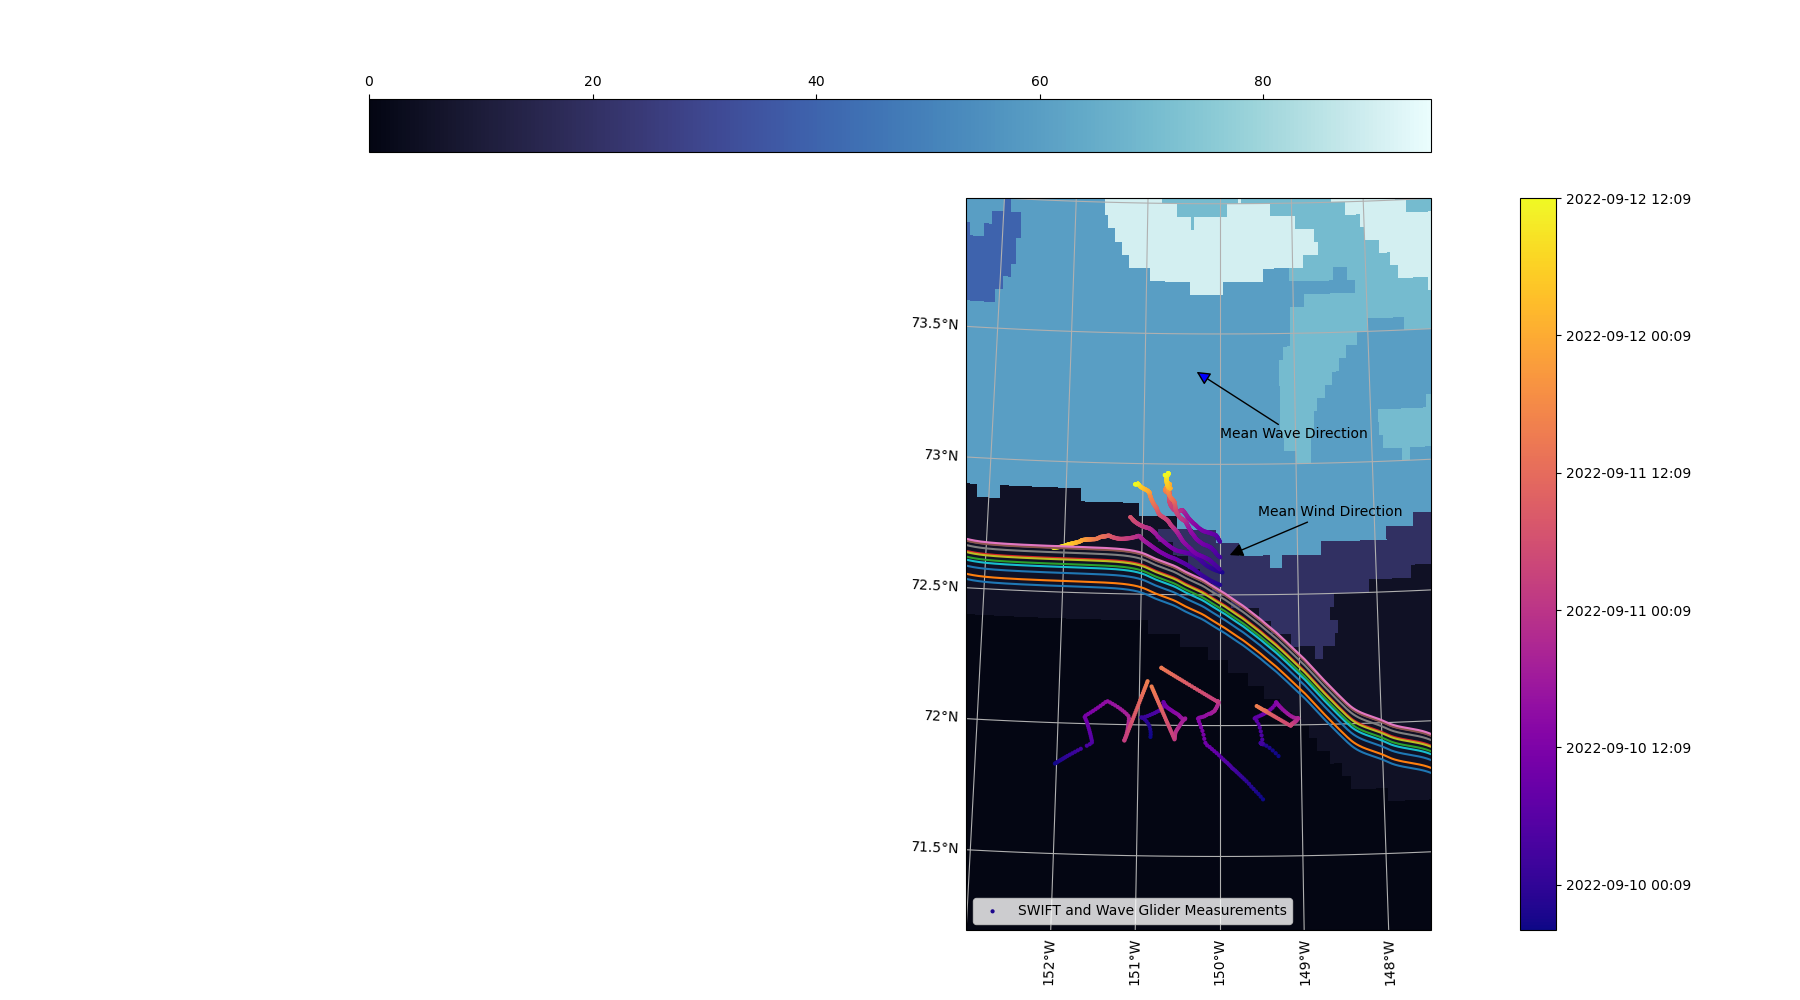

In [ ]:
# Plot the Effective Ice Edges
# Plot the ice map data
CRS = cartopy.crs.NorthPolarStereo(central_longitude=-150)
FIG_SIZE = (18, 10)
EXTENT = [-153, -147.5, 71.2, 74]
OCEAN_COLOR = 'blue'

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
# ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = True
gridlines.right_labels = False

# Plot the mean wave direction
mean_wave_dir = np.mean(df['wave_direction'])
print(mean_wave_dir) # this is in the convention that waves are coming from this direction
ax.annotate("Mean Wave Direction", 
            xy=(-150 + 0.4*np.cos(np.deg2rad(270 - mean_wave_dir)), 73.1 + 0.4*np.sin(np.deg2rad(270 - mean_wave_dir))), 
            xytext=(-150, 73.1), 
            xycoords=cartopy.crs.PlateCarree()._as_mpl_transform(ax),
            arrowprops=dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0, fc='b'))

# Plot the mean wind direction
mean_wind_dir = np.mean(df['winddir'])
print(mean_wind_dir) # Convention that wind is coming from this direction
ax.annotate("Mean Wind Direction", 
            xy=(-149.5 + 0.4*np.cos(np.deg2rad(270 - mean_wind_dir)), 72.8 + 0.4*np.sin(np.deg2rad(270 - mean_wind_dir))), 
            xytext=(-149.5, 72.8), 
            xycoords=cartopy.crs.PlateCarree()._as_mpl_transform(ax),
            arrowprops=dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0, fc='k'))

# Plot the ice map data
im1 = ax.pcolormesh(ice_map_lon, ice_map_lat, ice_concentration,
              transform=cartopy.crs.PlateCarree(), cmap=cmocean.cm.ice, zorder=0)
cbar1 = fig.colorbar(im1, location='top', shrink=0.6)
cbar1.ax.set_label('Ice Concentration [%]')

# # Plot locations of SWIFTs and Wavegliders
im2 = ax.scatter(df['longitude'], df['latitude'], c=date_numbers, cmap='plasma', s=4, transform=cartopy.crs.PlateCarree(), label='SWIFT and Wave Glider Measurements')
cbar = fig.colorbar(im2)
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%m'))
cbar.ax.set_label('Time of Measurement [UTC]')

# Plot Ice Concentration Contours
# ax.plot(lon_80percent, lat_80percent, color='k', label='80% Ice Concentration', transform=cartopy.crs.PlateCarree())
# ax.plot(lon_15percent, lat_15percent, color='b', label='15% Ice Concentration', transform=cartopy.crs.PlateCarree())
# ax.plot(ice_edge_df['lon'], ice_edge_df['2022-09-10 00:00:00'], transform=cartopy.crs.PlateCarree())
ax.plot(ice_edge_df['lon'], ice_edge_df[time_window_centers_list], transform=cartopy.crs.PlateCarree())


# Axes properties
ax.set_xlabel('Longitude [Degrees West]')
ax.set_ylabel('Latitude [Degrees North]')
ax.legend(loc='lower left')
plt.tight_layout()

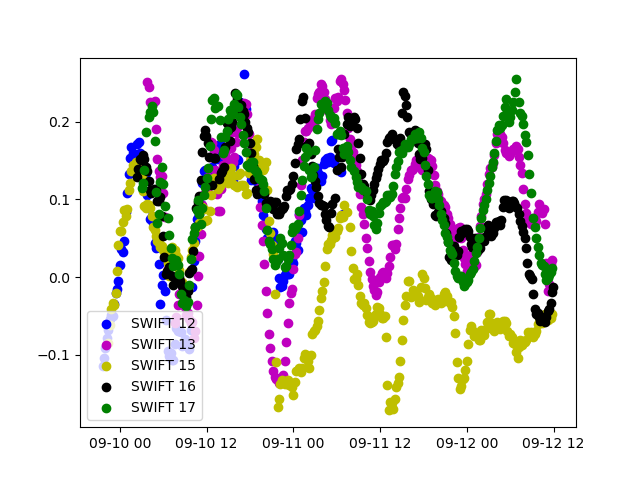

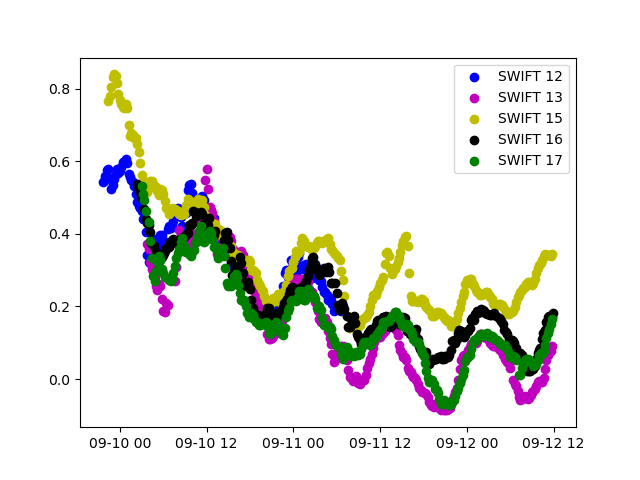

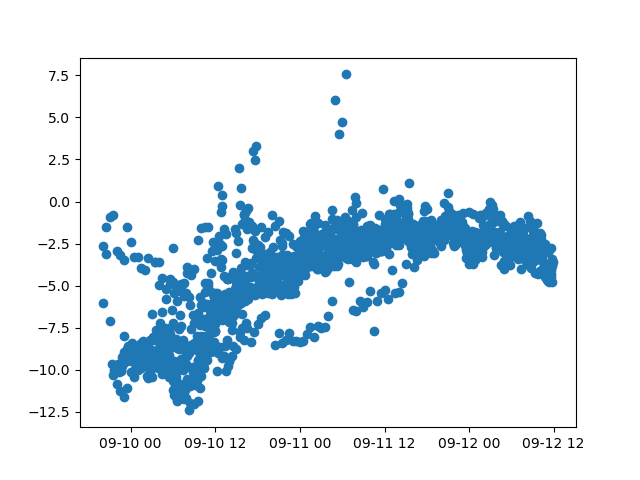

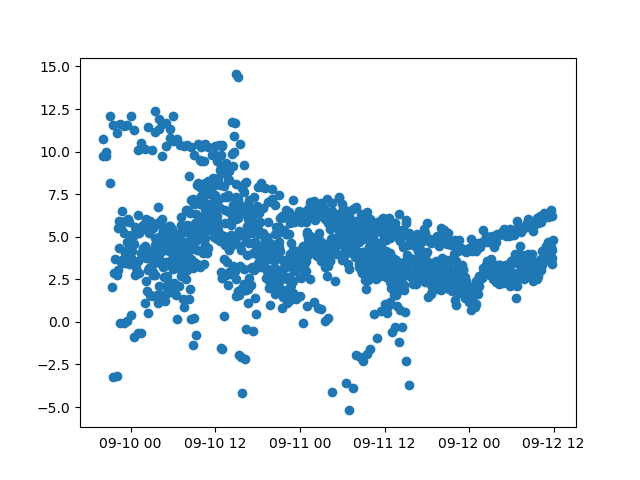

In [ ]:
# Plot the Drift Speed and Direction
fig, ax = plt.subplots()
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==12, 'time']), df.loc[df['swiftnum']==12, 'cross ice drift speed'], color='b', label='SWIFT 12')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==13, 'time']), df.loc[df['swiftnum']==13, 'cross ice drift speed'], color='m', label='SWIFT 13')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==15, 'time']), df.loc[df['swiftnum']==15, 'cross ice drift speed'], color='y', label='SWIFT 15')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==16, 'time']), df.loc[df['swiftnum']==16, 'cross ice drift speed'], color='k', label='SWIFT 16')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==17, 'time']), df.loc[df['swiftnum']==17, 'cross ice drift speed'], color='g', label='SWIFT 17')
ax.legend()

fig, ax = plt.subplots()
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==12, 'time']), df.loc[df['swiftnum']==12, 'along ice drift speed'], color='b', label='SWIFT 12')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==13, 'time']), df.loc[df['swiftnum']==13, 'along ice drift speed'], color='m', label='SWIFT 13')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==15, 'time']), df.loc[df['swiftnum']==15, 'along ice drift speed'], color='y', label='SWIFT 15')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==16, 'time']), df.loc[df['swiftnum']==16, 'along ice drift speed'], color='k', label='SWIFT 16')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==17, 'time']), df.loc[df['swiftnum']==17, 'along ice drift speed'], color='g', label='SWIFT 17')
ax.legend()

fig, ax = plt.subplots()
ax.scatter(pd.to_datetime(df['time']), df['cross ice wind speed'])

fig, ax = plt.subplots()
ax.scatter(pd.to_datetime(df['time']), df['along ice wind speed'])



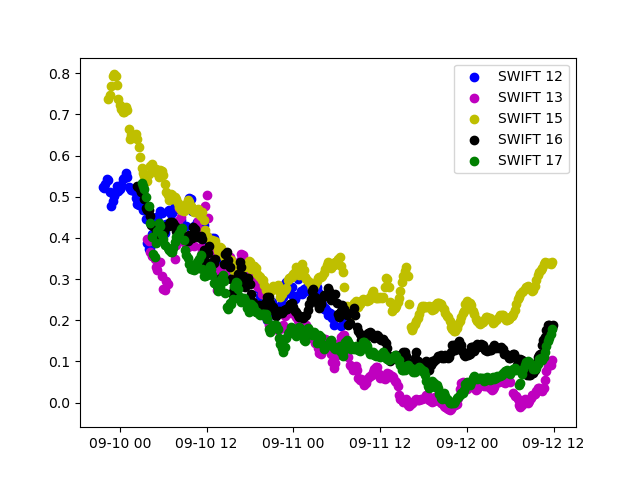

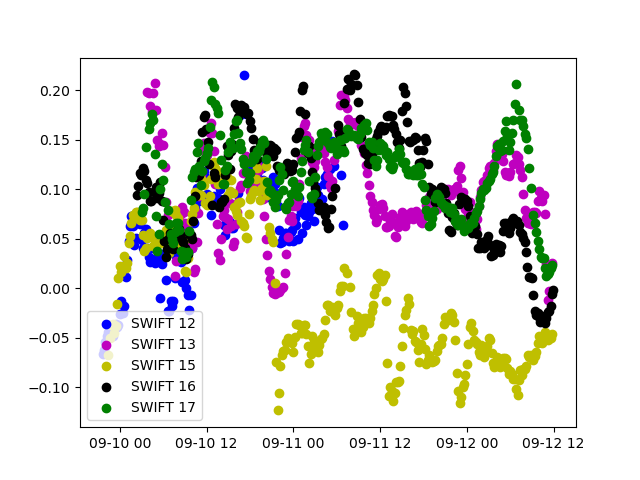

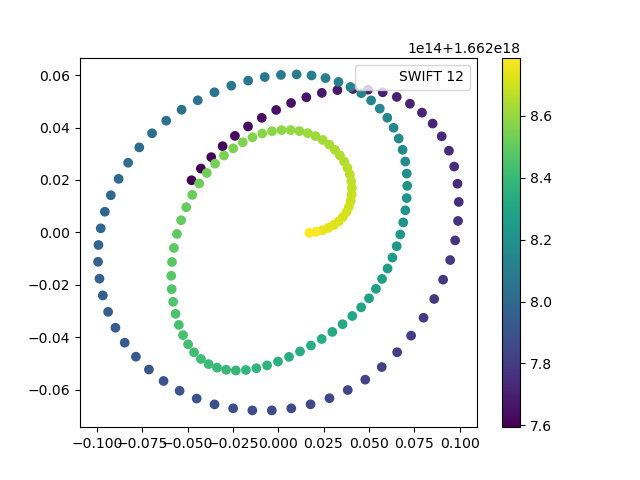

In [ ]:
# Filtering the Drift Speeds
# x_iceedge_interp = np.arange(-100000, 200000, num=50000)
# # y_iceedge_interp = np.interp(x_iceedge_interp, x_iceedge, y_iceedge)
# print(time[0])
# print(time[1])
#  print(type(time[1] - time[0]))
# print((time[1] - time[0]).item().total_seconds())
swift_nums = [12, 13, 15, 16, 17]

for num in swift_nums:
    # inds = ~np.isnan(df.loc[df['swiftnum']==num, 'along ice drift speed']) & (df['swiftnum']==num)
    # along_ice_drift_nofilt = np.array(df.loc[inds, 'along ice drift speed'])
    # cross_ice_drift_nofilt = np.array(df.loc[inds, 'cross ice drift speed'])
    inds = ~np.isnan(df.loc[df['swiftnum']==num, 'along ice drift speed']) & (df['swiftnum']==num)
    along_ice_drift_nofilt = np.array(df.loc[inds, 'along ice drift speed'])
    cross_ice_drift_nofilt = np.array(df.loc[inds, 'cross ice drift speed'])

    time_step = (12 * 60)
    fs = 1 / time_step

    # Compute Inertial Oscillation Frequnecy for the cutoff
    inertial_period = 12.5 # Hours
    inertial_period_seconds = 12.5 * 3600
    filter_cutoff_seconds = inertial_period_seconds
    cutoff = 1 / filter_cutoff_seconds

    # Define Filter Order and Nyquist
    nyq = 0.5 * fs
    order = 1
    
    # Low Pass Filter
    # cutoff = 1 / inertial_period_seconds
    # normal_cutoff = cutoff / nyq
    # b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)

    # Band pass filter
    low = (1/(15 * 3600)) / nyq
    high = (1/(9 * 3600)) / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    along_ice_drift_filt = signal.filtfilt(b, a, along_ice_drift_nofilt)
    cross_ice_drift_filt = signal.filtfilt(b, a, cross_ice_drift_nofilt)

    # Save the filtered signals
    df.loc[inds, 'along ice drift speed filt'] = along_ice_drift_nofilt - along_ice_drift_filt
    df.loc[inds, 'along ice inertial drift speed'] = along_ice_drift_filt
    df.loc[inds, 'cross ice drift speed filt'] = cross_ice_drift_nofilt - cross_ice_drift_filt
    df.loc[inds, 'cross ice inertial drift speed'] = cross_ice_drift_filt

fig, ax = plt.subplots()
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==12, 'time']), df.loc[df['swiftnum']==12, 'along ice drift speed filt'], color='b', label='SWIFT 12')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==13, 'time']), df.loc[df['swiftnum']==13, 'along ice drift speed filt'], color='m', label='SWIFT 13')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==15, 'time']), df.loc[df['swiftnum']==15, 'along ice drift speed filt'], color='y', label='SWIFT 15')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==16, 'time']), df.loc[df['swiftnum']==16, 'along ice drift speed filt'], color='k', label='SWIFT 16')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==17, 'time']), df.loc[df['swiftnum']==17, 'along ice drift speed filt'], color='g', label='SWIFT 17')
ax.legend()

fig, ax = plt.subplots()
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==12, 'time']), df.loc[df['swiftnum']==12, 'cross ice drift speed filt'], color='b', label='SWIFT 12')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==13, 'time']), df.loc[df['swiftnum']==13, 'cross ice drift speed filt'], color='m', label='SWIFT 13')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==15, 'time']), df.loc[df['swiftnum']==15, 'cross ice drift speed filt'], color='y', label='SWIFT 15')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==16, 'time']), df.loc[df['swiftnum']==16, 'cross ice drift speed filt'], color='k', label='SWIFT 16')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==17, 'time']), df.loc[df['swiftnum']==17, 'cross ice drift speed filt'], color='g', label='SWIFT 17')
ax.legend()

fig, ax = plt.subplots()
im = ax.scatter(df.loc[df['swiftnum']==12, 'cross ice inertial drift speed'], df.loc[df['swiftnum']==12, 'along ice inertial drift speed'], c=pd.to_datetime(df.loc[df['swiftnum']==12, 'time']), label='SWIFT 12')
cbar = plt.colorbar(im)
# ax.scatter(df.loc[df['swiftnum']==12, 'cross ice inertial drift speed'], df.loc[df['swiftnum']==12, 'along ice inertial drift speed'], color='b', label='SWIFT 12')
# ax.scatter(df.loc[df['swiftnum']==13, 'cross ice inertial drift speed'], df.loc[df['swiftnum']==13, 'along ice inertial drift speed'], color='m', label='SWIFT 13')
# ax.scatter(df.loc[df['swiftnum']==15, 'cross ice inertial drift speed'], df.loc[df['swiftnum']==15, 'along ice inertial drift speed'], color='y', label='SWIFT 15')
# ax.scatter(df.loc[df['swiftnum']==16, 'cross ice inertial drift speed'], df.loc[df['swiftnum']==16, 'along ice inertial drift speed'], color='k', label='SWIFT 16')
# ax.scatter(df.loc[df['swiftnum']==17, 'cross ice inertial drift speed'], df.loc[df['swiftnum']==17, 'along ice inertial drift speed'], color='g', label='SWIFT 17')
ax.legend()


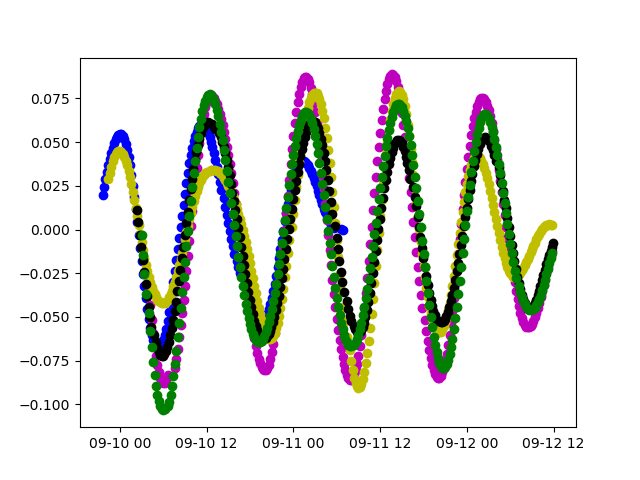

In [ ]:
# Fit a curve to the inertial drift speed - along ice
fig, ax = plt.subplots()
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==12, 'time']), df.loc[df['swiftnum']==12, 'along ice inertial drift speed'], color='b', label='SWIFT 12')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==13, 'time']), df.loc[df['swiftnum']==13, 'along ice inertial drift speed'], color='m', label='SWIFT 13')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==15, 'time']), df.loc[df['swiftnum']==15, 'along ice inertial drift speed'], color='y', label='SWIFT 15')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==16, 'time']), df.loc[df['swiftnum']==16, 'along ice inertial drift speed'], color='k', label='SWIFT 16')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==17, 'time']), df.loc[df['swiftnum']==17, 'along ice inertial drift speed'], color='g', label='SWIFT 17')

# Fit a curve to the inertial oscillation data so that
# ax.scatter(pd.to_datetime(df['time']), np.nanmean(df['along ice inertial drift speed']), color='g', label='Average')



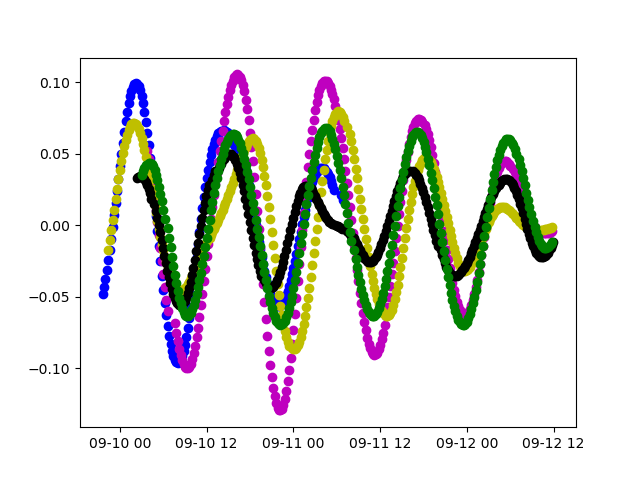

In [ ]:
# Fit a curve to the inertial drift speed - cross ice
fig, ax = plt.subplots()
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==12, 'time']), df.loc[df['swiftnum']==12, 'cross ice inertial drift speed'], color='b', label='SWIFT 12')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==13, 'time']), df.loc[df['swiftnum']==13, 'cross ice inertial drift speed'], color='m', label='SWIFT 13')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==15, 'time']), df.loc[df['swiftnum']==15, 'cross ice inertial drift speed'], color='y', label='SWIFT 15')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==16, 'time']), df.loc[df['swiftnum']==16, 'cross ice inertial drift speed'], color='k', label='SWIFT 16')
ax.scatter(pd.to_datetime(df.loc[df['swiftnum']==17, 'time']), df.loc[df['swiftnum']==17, 'cross ice inertial drift speed'], color='g', label='SWIFT 17')

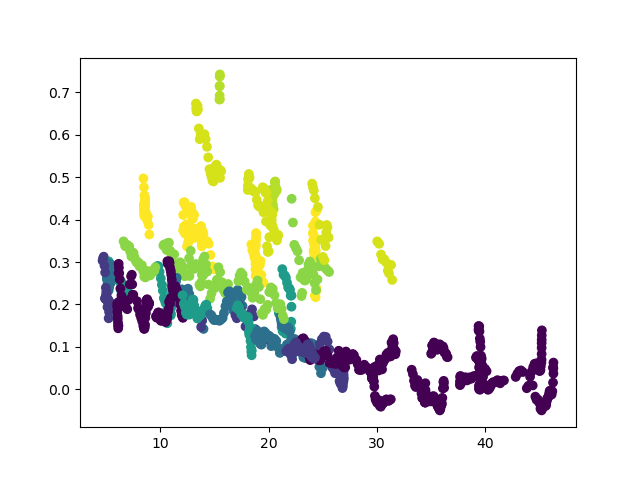

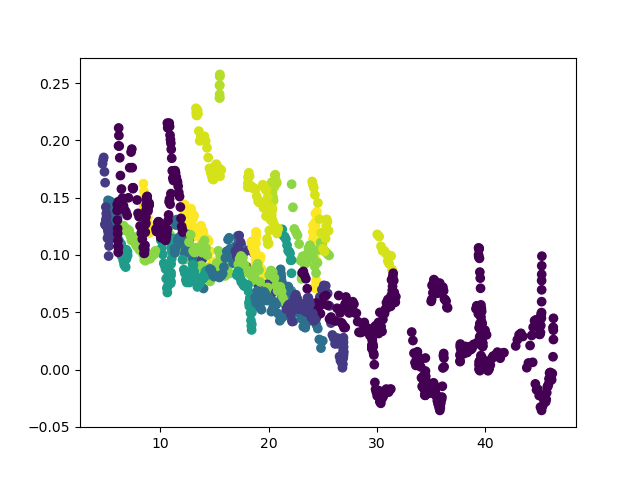

In [ ]:
fig, ax = plt.subplots()
ax.scatter(df['cross ice distance']/1000, df['along ice drift speed filt'], c=df['H0'])


fig, ax = plt.subplots()
ax.scatter(df['cross ice distance']/1000, df['along ice drift speed filt']/df['H0'], c=df['H0'])

[0.00051186]


/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_23550/3768863335.py:5: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(1/C_d) * np.exp(-alpha * x)


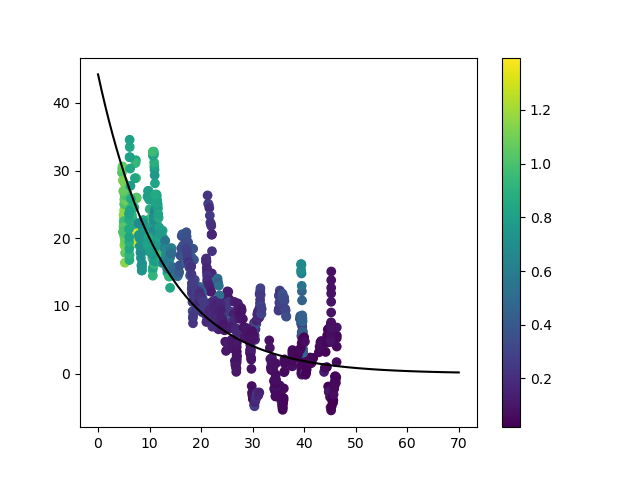

In [ ]:
# Normalize the along ice drift by the wave height and angle with decay rate
along_ice_drift_norm = df['along ice drift speed filt'] * (np.sqrt(8) / (df['H0'] * np.sqrt(average_alpha * 9.8 * np.cos(df['theta0 avg [rad]']) * np.sin(df['theta0 avg [rad]']))))

def fit_norm_along_ice_drift(x, C_d, alpha=average_alpha):
    return np.sqrt(1/C_d) * np.exp(-alpha * x)

x = np.array(df['cross ice distance'])
y = along_ice_drift_norm

popt, _ = curve_fit(fit_norm_along_ice_drift, x, y, p0=(8*10**(-3)), nan_policy='omit')
C_d = popt   
print(C_d)


fig, ax = plt.subplots()
im = ax.scatter(df['cross ice distance']/1000, along_ice_drift_norm, c=df['hs'])
cbar = plt.colorbar(im)
ax.plot(np.linspace(0, 70000, num=100)/1000, fit_norm_along_ice_drift(np.linspace(0, 70000, num=100), C_d, average_alpha), color='k')

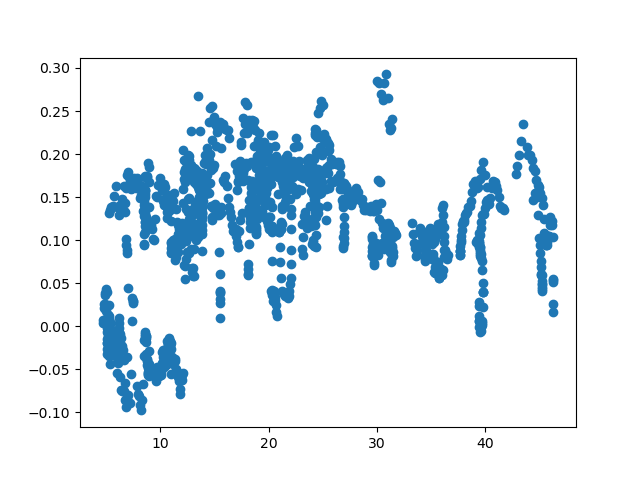

In [ ]:
fig, ax = plt.subplots()
ax.scatter(df['cross ice distance']/1000, df['cross ice drift speed filt'])

In [ ]:
# Exclude NaN values from the data
# Define constants and initial guesses
initial_guess = [2.9*10**(-3),30000]

# Define the function to fit the data to
def wave_height_decay_model(x, alpha, horizontal_offset):
    return np.exp(-alpha * (x - horizontal_offset))

# Fit the exponential decay model for wave height to solve for decay rate and 
inds = (cross_ice_distance_initial > 0) & (df['time'] > '2022-09-11 00:00:00') & (df['time'] <= '2022-09-11 06:00:00')
x = cross_ice_distance_initial[inds]
y = df.loc[inds, 'hs norm']
popt, _ = curve_fit(wave_height_decay_model, x, y, p0=initial_guess, nan_policy='omit') 
alpha, horizontal_offset = popt

print(H0)
print(alpha)
print(horizontal_offset)

# Compute a curve for the wave height decay
x_vals = np.linspace(horizontal_offset, 70000, num=100)
wave_decay_curve = wave_height_decay_model(x_vals, alpha, horizontal_offset)


# Plot the Normlaized Wave Heights
fig, ax = plt.subplots()
im = ax.scatter(cross_ice_distance_initial[inds], df.loc[inds, 'hs norm'], c=pd.to_datetime(df.loc[inds, 'time']))
# cbar = plt.colorbar(im)
ax.plot(x_vals, wave_decay_curve, color='k', label=f'Wave Height Decay Model, alpha = {np.round(alpha, 6)}')
ax.plot([-70000, horizontal_offset], [1, 1], color='k')
ax.axvline(horizontal_offset, color='k', linestyle='dashed', label=f'Effective Ice Edge, x = {np.round(horizontal_offset, 2)} meters')
ax.set_xlabel('Cross Ice Distance [m]')
ax.set_ylabel('Significant Wave Height [m]')
ax.legend()

# Plot the Normlaized Wave Heights
fig, ax = plt.subplots()
im = ax.scatter(cross_ice_distance_initial[inds] - horizontal_offset, df.loc[inds, 'hs norm'], c=pd.to_datetime(df.loc[inds, 'time']))
# cbar = plt.colorbar(im)
ax.plot(np.linspace(0, 70000, num=100), np.exp(-(8.27*10**(-5)) * np.linspace(0, 70000, num=100)), color='k')
# ax.plot([-70000, horizontal_offset], [1, 1], color='k')
# ax.axvline(horizontal_offset, color='k', linestyle='dashed', label=f'Effective Ice Edge, x = {np.round(horizontal_offset, 2)} meters')
ax.set_xlabel('Cross Ice Distance [m]')
ax.set_ylabel('Significant Wave Height [m]')
ax.legend()

In [ ]:
avg_attenuation_rate = np.mean([5.6, 5.8, 8.7, 9.4, 10.4, 9.2, 8.8])* 10**(-5)
print(avg_attenuation_rate)
avg_effective_ice_edge = np.mean([10958, 13143, 20384, 22823, 27278, 27135, 27919])
print(avg_effective_ice_edge)

x_vals = np.linspace(0, 70000, num=100)

fig, ax = plt.subplots()
ax.plot(x_vals, np.exp(-5.6*10**(-5) * (x_vals)))
ax.plot(x_vals, np.exp(-5.8*10**(-5) * (x_vals)))
ax.plot(x_vals, np.exp(-8.7*10**(-5) * (x_vals)))
ax.plot(x_vals, np.exp(-9.4*10**(-5) * (x_vals)))
ax.plot(x_vals, np.exp(-10.4*10**(-5) * (x_vals)))
ax.plot(x_vals, np.exp(-9.2*10**(-5) * (x_vals)))
ax.plot(x_vals, np.exp(-8.8*10**(-5) * (x_vals)))
ax.plot(x_vals, np.exp(-8.27*10**(-5) * (x_vals)), color='k', linewidth=5)


In [ ]:
# Recreate the plot above in lat and lon coordinates as a first paper figure
x_iceedge = x_1percent_contour
y_iceedge = y_1percent_contour + horizontal_offset
lat_iceedge, lon_iceedge = local_to_latlon(x_iceedge, y_iceedge, lat_0, lon_0)

# Plot the ice map data
CRS = cartopy.crs.NorthPolarStereo(central_longitude=-150)
FIG_SIZE = (20, 10)
EXTENT = [-153, -147.5, 71.2, 74]
OCEAN_COLOR = 'blue'

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
# ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = True
gridlines.right_labels = False

# Plot the mean wave direction
mean_wave_dir = np.mean(df['wave_direction'])
print(mean_wave_dir) # this is in the convention that waves are coming from this direction
ax.annotate("Mean Wave Direction", 
            xy=(-150 + 0.4*np.cos(np.deg2rad(270 - mean_wave_dir)), 73.1 + 0.4*np.sin(np.deg2rad(270 - mean_wave_dir))), 
            xytext=(-150, 73.1), 
            xycoords=cartopy.crs.PlateCarree()._as_mpl_transform(ax),
            arrowprops=dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0, fc='b'))

# Plot the mean wind direction
mean_wind_dir = np.mean(df['winddir'])
print(mean_wind_dir) # Convention that wind is coming from this direction
ax.annotate("Mean Wind Direction", 
            xy=(-149.5 + 0.4*np.cos(np.deg2rad(270 - mean_wind_dir)), 72.8 + 0.4*np.sin(np.deg2rad(270 - mean_wind_dir))), 
            xytext=(-149.5, 72.8), 
            xycoords=cartopy.crs.PlateCarree()._as_mpl_transform(ax),
            arrowprops=dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0, fc='k'))

# Plot the ice map data
im1 = ax.pcolormesh(ice_map_lon, ice_map_lat, ice_concentration,
              transform=cartopy.crs.PlateCarree(), cmap=cmocean.cm.ice, zorder=0)
# cbar1 = fig.colorbar(im1, location='top', shrink=0.6)
# cbar1.ax.set_label('Ice Concentration [%]')

# # Plot locations of SWIFTs and Wavegliders
im2 = ax.scatter(df['longitude'], df['latitude'], c=date_numbers, cmap='plasma', s=4, transform=cartopy.crs.PlateCarree(), label='SWIFT and Wave Glider Measurements')
# cbar = fig.colorbar(im2)
# cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%m'))
# cbar.ax.set_label('Time of Measurement [UTC]')

# Plot Ice Concentration Contours
ax.plot(lon_80percent, lat_80percent, color='k', label='80% Ice Concentration', transform=cartopy.crs.PlateCarree())
ax.plot(lon_15percent, lat_15percent, color='b', label='15% Ice Concentration', transform=cartopy.crs.PlateCarree())
ax.plot(lon_iceedge, lat_iceedge, color='m', label='Effective Ice Edge', transform=cartopy.crs.PlateCarree())
ax.plot(lon_1percent, lat_1percent, color='r', label='1% Ice Concentration', transform=cartopy.crs.PlateCarree())

# Axes properties
ax.set_xlabel('Longitude [Degrees West]')
ax.set_ylabel('Latitude [Degrees North]')
ax.legend(loc='lower left', fontsize=20)
ax.tick_params(axis='both', labelsize=20)
plt.tight_layout()

In [ ]:
# Recompute the cross ice distance beased on the new solved for ice edge
cross_ice_distance, indices = compute_cross_ice_distance(x_swifts_gliders, y_swifts_gliders, x_iceedge, y_iceedge)

fig, ax = plt.subplots()
ax.scatter(datetimes, cross_ice_distance)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(datetimes, df['hs'], c=cross_ice_distance)

In [ ]:
# Project the drift vectors and wind vectors into the ice coordinate system
def project_vector_to_ice(vx, vy, indices, x_iceedge, y_iceedge):
    """
    Projects a vector into the cross-ice and along-ice directions based on the ice edge orientation.
    
    Parameters:
        vx (array-like): An array of x components of the vector.
        vy (array-like): An array of y components of the vector.
        indices (array-like): Indices of the closest ice edge points.
        ice_x (array-like): An array of x coordinates defining the ice edge.
        ice_y (array-like): An array of y coordinates defining the ice edge.
    
    Returns:
        tuple: (numpy.ndarray of cross-ice components, numpy.ndarray of along-ice components)
    """
    # Compute Along Ice difference
    # Both negative so that positive is in the direction of drift
    along_ice_dx = np.zeros(x_iceedge.size)
    along_ice_dx[:-1] = -np.diff(x_iceedge)
    along_ice_dx[-1] = along_ice_dx[-2]
    along_ice_dy = np.zeros(x_iceedge.size)
    along_ice_dy[:-1] = -np.diff(y_iceedge)
    along_ice_dy[-1] = along_ice_dy[-2]

    # Smooth the computed slope
    fs = 1 / (x_iceedge[1] - x_iceedge[0])
    cutoff = 1/40000
    order = 3
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    along_ice_dy = signal.filtfilt(b, a, along_ice_dy)

    norm = np.sqrt(along_ice_dx**2 + along_ice_dy**2)
    along_ice_dx_norm = along_ice_dx / norm
    along_ice_dy_norm = along_ice_dy / norm

    # Make both negative so positive is into the ice 
    cross_ice_dx_norm = -(-along_ice_dy_norm)
    cross_ice_dy_norm = -(along_ice_dx_norm)
    
    # Get the local unit vectors for each point
    along_x = along_ice_dx_norm[indices]
    along_y = along_ice_dy_norm[indices]
    cross_x = cross_ice_dx_norm[indices]
    cross_y = cross_ice_dy_norm[indices]
    
    # Project the vector components onto the ice edge directions
    cross_ice = vx * cross_x + vy * cross_y
    along_ice = vx * along_x + vy * along_y
    
    return cross_ice, along_ice

# Compute the projection of the drift onto the ice edge
cross_ice_drift_speed, along_ice_drift_speed = project_vector_to_ice(df['EW_drift_speed'], df['NS_drift_speed'], 
                                                                     indices, x_iceedge, y_iceedge)

fig, ax = plt.subplots()
im = ax.scatter(datetimes, along_ice_drift_speed, c=cross_ice_distance, cmap='viridis')
cbar = plt.colorbar(im)
cbar.set_label('Cross Ice Distance [m]')
ax.set_xlabel('Time')
ax.set_ylabel('Along Ice Drift Speed [m/s]')

fig, ax = plt.subplots()
im = ax.scatter(datetimes, cross_ice_drift_speed, c=cross_ice_distance, cmap='viridis')
cbar = plt.colorbar(im)
cbar.set_label('Cross Ice Distance [m]')
ax.set_xlabel('Time')
ax.set_ylabel('Cross Ice Drift Speed [m/s]')

fig, ax = plt.subplots()
im = ax.scatter(cross_ice_distance, df['drift_speed'], c=date_numbers, cmap='inferno')
cbar = fig.colorbar(im)
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%m'))
ax.set_xlabel('Cross Ice Distance [m]')
ax.set_ylabel('Total Drift Speed [m/s]')
ax.set_xlim(0, 65000)

fig, ax = plt.subplots()
im = ax.scatter(cross_ice_distance, along_ice_drift_speed, c=date_numbers, cmap='inferno')
cbar = fig.colorbar(im)
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%m'))
ax.set_xlabel('Cross Ice Distance [m]')
ax.set_ylabel('Along Ice Drift Speed [m/s]')
ax.set_xlim(0, 65000)

fig, ax = plt.subplots()
im = ax.scatter(cross_ice_distance, cross_ice_drift_speed, c=date_numbers, cmap='inferno')
cbar = fig.colorbar(im)
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%m'))
ax.set_xlabel('Cross Ice Distance [m]')
ax.set_ylabel('Cross Ice Drift Speed [m/s]')
ax.set_xlim(0, 65000)

fig, ax = plt.subplots()
im = ax.scatter(cross_ice_distance, df['hs'], c=date_numbers, cmap='inferno')
cbar = fig.colorbar(im)
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%m'))
ax.set_xlabel('Cross Ice Distance [m]')
ax.set_ylabel('Significant Wave Height [m]')

In [ ]:
np.mean(cross_ice_drift_speed)

In [ ]:
# Compute Inertial period 
mean_lat = np.mean(df['latitude'])
print(mean_lat)


In [ ]:
# Look at Wind Speed
# Compute the projection of the drift onto the ice edge
cross_ice_wind_speed, along_ice_wind_speed = project_vector_to_ice(df['EW_wind_speed'], df['NS_wind_speed'], 
                                                                     indices, x_iceedge, y_iceedge)

# Bin average in time
# Compute Bin Averages of Along Ice Drift Speed
bin_num = 30
datenum_bin_avg, \
ai_windage_bin_avg, \
ai_windage_bin_count, ai_windage_std_in_bin = binned_statistics(date_numbers, 
                                                                0.0109*along_ice_wind_speed, 
                                                                bins=bin_num, statistic='mean')

datetime_bin_avg = np.squeeze(mdates.num2date(datenum_bin_avg))

fig, ax = plt.subplots()
ax.scatter(datetimes, 0.0109*along_ice_wind_speed, label='Along Ice Wind Speed Measurement', color='gray', alpha=0.5)
ax.errorbar(datetime_bin_avg, ai_windage_bin_avg, ai_windage_std_in_bin, fmt='o', linestyle='none', 
            capsize=3, label='Mean $\pm$ 1 Standard Deviation', color='r')
ax.axhline(np.mean(0.0109*along_ice_wind_speed), color='k')
ax.set_ylim(-0.2, 0.3)
ax.set_ylabel('SWIFT Windage [m/s]')

print(np.mean(0.0109*along_ice_wind_speed))



In [ ]:
# Filter out inertial oscillations from drift speed


In [ ]:
fig, ax = plt.subplots()
im = ax.scatter(datetimes, along_ice_drift_speed, c=cross_ice_distance, cmap='viridis')
ax.errorbar(datetime_bin_avg, ai_windage_bin_avg, ai_windage_std_in_bin, fmt='o', linestyle='none', 
            capsize=3, label='Mean $\pm$ 1 Standard Deviation', color='r')
cbar = plt.colorbar(im)
cbar.set_label('Cross Ice Distance [m]')
ax.set_xlabel('Time')
ax.set_ylabel('Along Ice Drift Speed [m/s]')

In [ ]:
# Compute Math Convention Wave Angle 
wave_angle_math_conv = 270 - mean_wave_dir

fig, ax = plt.subplots()
ax.plot(x_iceedge, y_iceedge)

# Compute the derivative of this line to get the slope at each point
y_iceedge_slope = np.gradient(y_iceedge, x_iceedge)

# Smooth the derivative
fs = 1 / (x_iceedge[1] - x_iceedge[0])
cutoff = 1/40000
order = 3
nyq = 0.5 * fs
normal_cutoff = cutoff / nyq
b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
y_iceedge_slope_smoothed = signal.filtfilt(b, a, y_iceedge_slope)

# Plot the slope and smoothed slope
fig, ax = plt.subplots()
ax.plot(x_iceedge, y_iceedge_slope, color='k')
ax.plot(x_iceedge, y_iceedge_slope_smoothed, color='r')
    
# Compute Along Ice difference
# Both negative so that positive is in the direction of drift
along_ice_dx = np.zeros(x_iceedge.size)
along_ice_dx[:-1] = -np.diff(x_iceedge)
along_ice_dx[-1] = along_ice_dx[-2]
along_ice_dy = np.zeros(x_iceedge.size)
along_ice_dy[:-1] = -np.diff(y_iceedge)
along_ice_dy[-1] = along_ice_dy[-2]
along_ice_dy = signal.filtfilt(b, a, along_ice_dy)

norm = np.sqrt(along_ice_dx**2 + along_ice_dy**2)
along_ice_dx_norm = along_ice_dx / norm
along_ice_dy_norm = along_ice_dy / norm

# Make both negative so positive is into the ice 
cross_ice_dx_norm = -(-along_ice_dy_norm)
cross_ice_dy_norm = -(along_ice_dx_norm)

# Compute the range for SWIFT measurements
SWIFT_indices = cross_ice_distance > 0
min_swift_ice_location = np.min(x_swifts_gliders[SWIFT_indices])
max_swift_ice_location = np.max(x_swifts_gliders[SWIFT_indices])
print(min_swift_ice_location)
print(max_swift_ice_location)

# Plot the Cartesian System
fig, ax = plt.subplots()
ax.plot(x_iceedge, y_iceedge, color='m')
ax.quiver(x_iceedge, y_iceedge, along_ice_dx_norm, along_ice_dy_norm, color='r', 
          scale=1, scale_units='xy', headwidth=5, headlength=8, width=0.01, pivot='middle')
ax.quiver(x_iceedge, y_iceedge, cross_ice_dx_norm, cross_ice_dy_norm, color='b', 
          scale=1, scale_units='xy', headwidth=5, headlength=8, width=0.01, pivot='middle')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.axis('equal')

# Compute the angle of each ice edge vector
along_ice_edge_angle_rad = np.abs(np.arctan2(along_ice_dy_norm, along_ice_dx_norm))
along_ice_edge_angle_deg = np.rad2deg(along_ice_edge_angle_rad)

# Compute the angle between the mean wave direction and the ice edge at every point
incidence_angle_deg = along_ice_edge_angle_deg - wave_angle_math_conv

# Compute the average incidence angle that the SWIFTs encounter
swift_range_inds = (x_iceedge > min_swift_ice_location) & (x_iceedge < max_swift_ice_location)
incidence_angle_deg_avg = np.mean(incidence_angle_deg[swift_range_inds])
incidence_angle_deg_min = np.min(incidence_angle_deg[swift_range_inds])
incidence_angle_deg_max = np.max(incidence_angle_deg[swift_range_inds])
incidence_angle_rad_avg = np.deg2rad(incidence_angle_deg_avg)
incidence_angle_rad_min = np.deg2rad(incidence_angle_deg_min)
incidence_angle_rad_max = np.deg2rad(incidence_angle_deg_max)

fig, ax = plt.subplots()
ax.scatter(x_iceedge, incidence_angle_deg, color='k')
ax.axvline(min_swift_ice_location, color='k', label='Min location of SWIFT')
ax.axvline(max_swift_ice_location, color='g', label='Max location of SWIFT')
ax.axhline(incidence_angle_deg_avg, color='r', label=f'Average Incident Angle = {np.round(incidence_angle_deg_avg, 2)} degrees')
ax.set_xlabel('X Location in Cartesian Coordinate System [m]')
ax.set_ylabel('Angle between ice edge and Mean Wave Angle [degrees]')
ax.legend(loc='lower left')





In [ ]:
# Solve for the Attenuation rate from teh significant wave height fit and the incidence angle 


In [ ]:
# Project the Wind Speed into the Direction of the ice
mean_wind_dir_math_conv = 270 - mean_wind_dir
mean_wind_mag = np.nanmean(df['windspd'])
print(mean_wind_dir_math_conv)
print(mean_wind_mag)

# Compute components of mean wind speed and direction
mean_wind_u = mean_wind_mag * np.cos(np.deg2rad(mean_wind_dir_math_conv))
mean_wind_v = mean_wind_mag * np.sin(np.deg2rad(mean_wind_dir_math_conv))

# Project the wind components onto the along ice direction 
wind_along_ice = (along_ice_dx_norm * mean_wind_u) + (along_ice_dy_norm * mean_wind_v)
mean_wind_along_ice = np.mean(wind_along_ice[swift_range_inds])

# Compute the Windage along the ice
mean_windage_u = 0.0109 * mean_wind_mag * np.cos(np.deg2rad(mean_wind_dir_math_conv))
mean_windage_v = 0.0109 * mean_wind_mag * np.sin(np.deg2rad(mean_wind_dir_math_conv))
windage_along_ice = (along_ice_dx_norm * mean_windage_u) + (along_ice_dy_norm * mean_windage_v)
mean_along_ice_windage_on_swift = np.mean(windage_along_ice[swift_range_inds])
print(mean_along_ice_windage_on_swift)

# Project the wind components onto the cross ice direction
wind_cross_ice = (cross_ice_dx_norm * mean_wind_u) + (cross_ice_dy_norm * mean_wind_v)
mean_wind_cross_ice = np.mean(wind_cross_ice)
windage_cross_ice = (cross_ice_dx_norm * mean_windage_u) + (cross_ice_dy_norm * mean_windage_v)
mean_cross_ice_windage_on_swift = np.mean(windage_cross_ice[swift_range_inds])
print(mean_cross_ice_windage_on_swift)

fig, ax = plt.subplots()
ax.scatter(x_iceedge, wind_along_ice)
ax.axhline(mean_wind_along_ice, label=f'Mean Wind Speed Along Ice Edge = {np.round(mean_wind_along_ice, 3)} m/s')
ax.set_xlabel('X location Ice Edge [m]')
ax.set_ylabel('Wind Speed Along Ice Edge [m/s]')
ax.axvline(min_swift_ice_location, color='k')
ax.axvline(max_swift_ice_location, color='k')
ax.set_ylim(0, 7)
ax.legend()

fig, ax = plt.subplots()
ax.scatter(x_iceedge, wind_cross_ice)
ax.axhline(mean_wind_cross_ice, label=f'Mean Wind Speed Cross Ice Edge = {np.round(mean_wind_cross_ice, 3)} m/s')
ax.set_xlabel('X location Ice Edge [m]')
ax.set_ylabel('Wind Speed Cross Ice Edge [m/s]')
ax.axvline(min_swift_ice_location, color='k')
ax.axvline(max_swift_ice_location, color='k')
ax.legend()


In [ ]:
# Compute Ekman Velocity and project it onto the ice edge

In [ ]:
# Define Constants and initial guess
theta = incidence_angle_rad_avg
initial_guess = [8*10**(-3), 0.1]

# Along Ice Drift model
def model_along_ice_drift_decay(x, C_d, ai_background_drift, H0=H0, alpha=alpha, theta=theta):
    return H0 * np.exp(-alpha * x) * np.sqrt((alpha * 9.8 * np.cos(theta) * np.sin(theta))/(8 * C_d)) + ai_background_drift

# Fit the model to the data
popt, _ = curve_fit(model_along_ice_drift_decay, cross_ice_distance, along_ice_drift_speed, p0=initial_guess, nan_policy='omit', bounds=([0, 0], [3, 0.3])) 
C_d, ai_background_drift = popt

print(C_d)
print(ai_background_drift)


# Compute Bin Averages of Along Ice Drift Speed
bin_num = 30
ai_cross_ice_bin_center, \
ai_drift_speed_avg, \
ai_drift_speed_bin_count, ai_drift_speed_std_in_bin = binned_statistics(cross_ice_distance, 
                                                                        along_ice_drift_speed, 
                                                                        bins=bin_num, statistic='mean')

# Create a curve for the model
x_ai_drift_model = np.linspace(0, 50000)
y_ai_drift_model = model_along_ice_drift_decay(x_ai_drift_model, C_d, ai_background_drift, H0, alpha, theta)

# Plot the Along Ice Drift Speed and Modeled 
fig, ax = plt.subplots()
ax.scatter(cross_ice_distance, along_ice_drift_speed, label='Along Ice Drift Speed Measurement', color='gray', alpha=0.5)
ax.errorbar(ai_cross_ice_bin_center, ai_drift_speed_avg, ai_drift_speed_std_in_bin, fmt='o', linestyle='none', 
            capsize=3, label='Mean $\pm$ 1 Standard Deviation', color='r')
ax.plot(x_ai_drift_model, y_ai_drift_model, color='k', label='Along Ice Drift Decay Model, Average Incident Angle')
ax.plot(x_ai_drift_model, model_along_ice_drift_decay(x_ai_drift_model, C_d, ai_background_drift, H0, alpha, incidence_angle_rad_max), 
        color='k', linestyle='dotted', label='Along Ice Drift Decay Model, Maximum Incident Angle')
ax.plot(x_ai_drift_model, model_along_ice_drift_decay(x_ai_drift_model, C_d, ai_background_drift, H0, alpha, incidence_angle_rad_min), 
        color='k', linestyle='dashed', label='Along Ice Drift Decay Model, Minimum Incident Angle')
ax.axhline(np.mean(0.0109*along_ice_wind_speed), color='blue', label='Direct Windage on SWIFT')
ax.set_xlabel('Cross Ice Distance [m]')
ax.set_ylabel('Along Ice Drift Speed [m/s]')
ax.legend()
ax.set_xlim(0, 50000)


In [ ]:
# Find the ice concentration at each point to see how these values vary with ice concentration

fig, ax = plt.subplots()
ax.plot(x_icemap[:,0])

# Check min and max values of concentration
print(np.max(ice_concentration))
print(np.min(ice_concentration))

# Define new points to get values for 
new_points = np.array([50000, 50000])

# Try interpn function
# print(interpolate.interpn((x_icemap[:,0], y_icemap[0,:]), ice_concentration), new_points)

# Define interpolator
interp_func = interpolate.RegularGridInterpolator((x_icemap[:,0], y_icemap[0,:]), ice_concentration)
new_point_test = interp_func(new_points)
print(new_point_test)


# new_points = np.transpose(np.array([x_swifts_gliders, y_swifts_gliders]))
# ice_concentration_at_swift_points = interp_func(new_points)


# ice_concentration_at_swift_points = np.zeros(x_swifts_gliders.shape)

# print(ice_concentration_at_swift_points.shape)
# print(cross_ice_distance.shape)
# print(ice_concentration_at_swift_points)

# # Plot the Cartesian System
# fig, ax = plt.subplots(figsize=(15,10))
# ax.plot(x_80percent_contour, y_80percent_contour, color='b', label='80% Ice Concentration')
# ax.plot(x_15percent_contour, y_15percent_contour, color='m', label='15% Ice Concentration')
# ax.plot(x_1percent_contour, y_1percent_contour, color='r', label='1% Ice Concentration')
# im3 = ax.scatter(x_swifts_gliders, y_swifts_gliders, c=ice_concentration_at_swift_points, cmap='viridis')
# cbar2 = fig.colorbar(im3)
# cbar2.set_label('Ice Concentration [%]')
# im2 = ax.pcolormesh(x_icemap, y_icemap, ice_concentration,
#                     cmap=cmocean.cm.ice, zorder=0)
# cbar = fig.colorbar(im2)
# cbar.set_label('Presence of Ice')
# ax.set_xlim(-100000, 200000)
# ax.set_ylim(-120000, 200000)
# ax.set_xlabel('X [m]')
# ax.set_ylabel('Y [m]')
# ax.legend()

# Plot the Along Ice Drift Speed as a function of Ice Concentration
# fig, ax = plt.subplots()
# ax.scatter(cross_ice_distance, ice_concentration_at_swift_points)


In [ ]:
# Compute Energy Flux as a function of Cross Shore Distance


# Wave Energy
# Note Rho may be changing based on salinity and temperaure - could be interesting to include that variation in this calculation
rho = 1025 # kg/m^3
g = 9.8
wave_energy = (1/16) * rho * g * df['hs']**2

fig, ax = plt.subplots()
ax.scatter(cross_ice_distance, wave_energy)
ax.set_xlabel('Cross Ice Distance [m]')
ax.set_ylabel('Wave Energy [J/m^2]')

# Compute the group velocity of the waves
# cg = 0.5c in deep water, and c = gT/2pi in deep water (confirmed on page 69 in Svendsen textbook)
c_g = 0.5 * (g * df['wave_period']) /(2 * np.pi)
fig, ax = plt.subplots()
ax.scatter(cross_ice_distance, c_g)
ax.set_xlabel('Cross Ice Distance [m]')
ax.set_ylabel('Group Velocity [m/s]')

# Compute Wave Energy Flux
wave_energy_flux = wave_energy * c_g

# Bin Average the wave Energy Flux
bin_num = 50
cross_ice_bin_center_ecg, \
wave_energy_flux_avg, \
wave_energy_flux_bin_count, \
wave_energy_flux_std_in_bin = binned_statistics(cross_ice_distance[cross_ice_distance > 0], 
                                                wave_energy_flux[cross_ice_distance > 0] , 
                                                bins=bin_num, statistic='mean')

fig, ax = plt.subplots()
ax.scatter(cross_ice_distance, wave_energy_flux, color='k', alpha=0.5)
ax.errorbar(cross_ice_bin_center_ecg, wave_energy_flux_avg, wave_energy_flux_std_in_bin, fmt='o', 
            linestyle='none', capsize=3, label='Mean $\pm$ 1 Standard Deviation', color='r')
ax.set_xlabel('Cross Ice Distance [m]')
ax.set_ylabel('Energy Flux [W/m]')
ax.set_xlim(0, 50000)
ax.set_ylim(0, 12000)

# Compute Energy Flux Gradient from the binned averages
dx = np.abs(cross_ice_bin_center_ecg[1] - cross_ice_bin_center_ecg[0])
wave_energy_flux_gradient = np.zeros(cross_ice_bin_center_ecg.size)
wave_energy_flux_gradient[:-1] = np.diff(wave_energy_flux_avg) / dx
wave_energy_flux_gradient[-1] = wave_energy_flux_gradient[-2]

# Normalize the wave energy flux gradient by density and ice thickness
h = 1
wave_energy_flux_gradient_norm = wave_energy_flux_gradient/(rho * h)

fig, ax = plt.subplots()
ax.scatter(cross_ice_bin_center_ecg, -wave_energy_flux_gradient_norm)
ax.set_yscale('log')
ax.set_xlabel('Cross Ice Distance [m]')
ax.set_ylabel('Wave Energy Flux Gradient [W/kg]')

In [ ]:
# Look at energy flux gradient (dissipation) as a function of the ice concentration

## Investigate the Temperature and Salinity in the ice coordiante system

In [ ]:
fig, ax = plt.subplots()
im = ax.scatter(cross_ice_distance, df['water_temperature'], c=date_numbers, cmap='inferno')
cbar = fig.colorbar(im)
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%m'))
ax.set_xlabel('Cross Ice Distance [m]')
ax.set_ylabel('Water Temperature [C]')

fig, ax = plt.subplots()
im = ax.scatter(cross_ice_distance, df['salinity'], c=date_numbers, cmap='inferno')
cbar = fig.colorbar(im)
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%m'))
ax.set_xlabel('Cross Ice Distance [m]')
ax.set_ylabel('Salinity [psu]')

In [ ]:
# Load data from the UpTempo Buoys
uptempo1_data = nc.Dataset('../data/SASSIE_Fall_2022_UpTempO_01_V2p.nc')
uptempo1_time = cftime.num2pydate(uptempo1_data['time'][:], units=uptempo1_data['time'].units)
print(datetimes[1] - datetimes[0])
print(uptempo1_time[1] - uptempo1_time[0])
# well uptempo is sampling at the same rate as the SWIFTs but it gives more data
print(uptempo1_time[0])
print(uptempo1_time[-1])

uptempo2_data = nc.Dataset('../data/SASSIE_Fall_2022_UpTempO_02_V2p.nc')
uptempo2_time = cftime.num2pydate(uptempo2_data['time'][:], units=uptempo2_data['time'].units)
print(datetimes[1] - datetimes[0])
print(uptempo2_time[1] - uptempo2_time[0])
# well uptempo is sampling at the same rate as the SWIFTs but it gives more data
print(uptempo2_time[0])
print(uptempo2_time[-1])

uptempo3_data = nc.Dataset('../data/SASSIE_Fall_2022_UpTempO_03_V2p.nc')
uptempo3_time = cftime.num2pydate(uptempo3_data['time'][:], units=uptempo3_data['time'].units)
print(datetimes[1] - datetimes[0])
print(uptempo3_time[1] - uptempo3_time[0])
# well uptempo is sampling at the same rate as the SWIFTs but it gives more data
print(uptempo3_time[0])
print(uptempo3_time[-1])

# Load data from the UpTempo Buoys
uptempo4_data = nc.Dataset('../data/SASSIE_Fall_2022_UpTempO_04_V2p.nc')
uptempo4_time = cftime.num2pydate(uptempo4_data['time'][:], units=uptempo4_data['time'].units)
print(datetimes[1] - datetimes[0])
print(uptempo4_time[1] - uptempo4_time[0])
# well uptempo is sampling at the same rate as the SWIFTs but it gives more data
print(uptempo4_time[0])
print(uptempo4_time[-1])

In [ ]:
# Plot the location of the UpTempo Drifters with the SWIFTs and Wave Gliders
# Plot the ice map data
CRS = cartopy.crs.NorthPolarStereo(central_longitude=-150)
FIG_SIZE = (18, 10)
EXTENT = [-153, -147.5, 71.2, 74]
OCEAN_COLOR = 'blue'

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
# ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = True
gridlines.right_labels = False

# Plot the mean wave direction
mean_wave_dir = np.mean(df['wave_direction'])
print(mean_wave_dir) # this is in the convention that waves are coming from this direction
ax.annotate("Mean Wave Direction", 
            xy=(-150 + 0.4*np.cos(np.deg2rad(270 - mean_wave_dir)), 73.1 + 0.4*np.sin(np.deg2rad(270 - mean_wave_dir))), 
            xytext=(-150, 73.1), 
            xycoords=cartopy.crs.PlateCarree()._as_mpl_transform(ax),
            arrowprops=dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0, fc='b'))

# Plot the mean wind direction
mean_wind_dir = np.mean(df['winddir'])
print(mean_wind_dir) # Convention that wind is coming from this direction
ax.annotate("Mean Wind Direction", 
            xy=(-149.5 + 0.4*np.cos(np.deg2rad(270 - mean_wind_dir)), 72.8 + 0.4*np.sin(np.deg2rad(270 - mean_wind_dir))), 
            xytext=(-149.5, 72.8), 
            xycoords=cartopy.crs.PlateCarree()._as_mpl_transform(ax),
            arrowprops=dict(arrowstyle="-|>,head_width=0.4,head_length=0.8",
            shrinkA=0,shrinkB=0, fc='k'))

# Plot the ice map data
im1 = ax.pcolormesh(ice_map_lon, ice_map_lat, ice_concentration,
              transform=cartopy.crs.PlateCarree(), cmap=cmocean.cm.ice, zorder=0)
cbar1 = fig.colorbar(im1, location='top', shrink=0.6)
cbar1.ax.set_label('Ice Concentration [%]')

# # Plot locations of SWIFTs and Wavegliders
im2 = ax.scatter(df['longitude'], df['latitude'], c=date_numbers, cmap='plasma', s=4, transform=cartopy.crs.PlateCarree(), label='SWIFT and Wave Glider Measurements')
cbar = fig.colorbar(im2)
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%m'))
cbar.ax.set_label('Time of Measurement [UTC]')

# Plot Ice Concentration Contours
ax.plot(lon_80percent, lat_80percent, color='k', label='80% Ice Concentration', transform=cartopy.crs.PlateCarree())
ax.plot(lon_15percent, lat_15percent, color='b', label='15% Ice Concentration', transform=cartopy.crs.PlateCarree())
ax.plot(lon_iceedge, lat_iceedge, color='m', label='Model Ice Edge', transform=cartopy.crs.PlateCarree())
ax.plot(lon_1percent, lat_1percent, color='r', label='1% Ice Concentration', transform=cartopy.crs.PlateCarree())

# Plot the UpTempo Location
ax.scatter(uptempo1_data['longitude'][:], uptempo1_data['latitude'][:], color='g', s=4, transform=cartopy.crs.PlateCarree(), label='UpTempo Drifters')
ax.scatter(uptempo2_data['longitude'][:], uptempo2_data['latitude'][:], color='g', s=4, transform=cartopy.crs.PlateCarree())
ax.scatter(uptempo3_data['longitude'][:], uptempo3_data['latitude'][:], color='g', s=4, transform=cartopy.crs.PlateCarree())
ax.scatter(uptempo4_data['longitude'][:], uptempo4_data['latitude'][:], color='g', s=4, transform=cartopy.crs.PlateCarree())

# Axes properties
ax.set_xlabel('Longitude [Degrees West]')
ax.set_ylabel('Latitude [Degrees North]')
ax.legend(loc='lower left')
plt.tight_layout()

Thought: If we assume the turbulence is stationary then we can compute the variance in a spatial bin from multiple instruments together. We can also aggregate multiple sensors in a spatial bin to create an estimate of the time series in a spatial bin. Are there reasonable assumptions?

# ------------ Current Analysis ends here ---------------

In [ ]:
# Bin the along ice drift v. cross ice distance plot
bin_num = 40
# Note here that the bins are computing correctly but the data includes measurements from the wave gliders which have NaN value
# drift speeds so those bins get NaN value statistics so the number of non NaN bins is different that stated here but 
# it is computing correctly
cross_ice_bin_center, \
along_ice_drift_speed_avg, \
along_ice_drift_speed_bin_count, std_in_bin = binned_statistics(cross_ice_distance, 
                                                    along_ice_drift_speed, 
                                                    bins=bin_num, statistic='mean')
cross_ice_bin_center, \
along_ice_drift_speed_median, \
along_ice_drift_speed_bin_count, std_in_bin = binned_statistics(cross_ice_distance, 
                                                    along_ice_drift_speed, 
                                                    bins=bin_num, statistic='median')

fig, ax = plt.subplots()
ax.errorbar(cross_ice_bin_center, along_ice_drift_speed_avg, std_in_bin, fmt='o', linestyle='none', capsize=3, label='Mean $\pm$ 1 Standard Deviation')
ax.errorbar(cross_ice_bin_center, along_ice_drift_speed_median, std_in_bin, fmt='o', linestyle='none', capsize=3,label='Median $\pm$ 1 Standard Deviation')
ax.set_xlabel('Cross Ice Distance [m]')
ax.set_ylabel('Along Ice Drift Speed [m/s]')
ax.set_xlim(-500, 70000)
ax.legend()

In [ ]:
# Bin the along ice drift v. cross ice distance plot
bin_num = 40
# Note here that the bins are computing correctly but the data includes measurements from the wave gliders which have NaN value
# drift speeds so those bins get NaN value statistics so the number of non NaN bins is different that stated here but 
# it is computing correctly
cross_ice_bin_center, \
cross_ice_drift_speed_avg, \
along_ice_drift_speed_bin_count, std_in_bin = binned_statistics(cross_ice_distance, 
                                                    cross_ice_drift_speed, 
                                                    bins=bin_num, statistic='mean')
cross_ice_bin_center, \
cross_ice_drift_speed_median, \
cross_ice_drift_speed_bin_count, std_in_bin = binned_statistics(cross_ice_distance, 
                                                    cross_ice_drift_speed, 
                                                    bins=bin_num, statistic='median')

fig, ax = plt.subplots()
ax.errorbar(cross_ice_bin_center, cross_ice_drift_speed_avg, std_in_bin, fmt='o', linestyle='none', capsize=3, label='Mean $\pm$ 1 Standard Deviation')
ax.errorbar(cross_ice_bin_center, cross_ice_drift_speed_median, std_in_bin, fmt='o', linestyle='none', capsize=3,label='Median $\pm$ 1 Standard Deviation')
ax.set_xlabel('Cross Ice Distance [m]')
ax.set_ylabel('Cross Ice Drift Speed [m/s]')
ax.set_xlim(-500, 70000)
ax.legend()

In [ ]:
# Compute the Decay Rate for the Along Ice Drift Attenuation
nonan_inds = ~np.isnan(along_ice_drift_speed_avg)
along_ice_drift_speed_avg_nonans = along_ice_drift_speed_avg[nonan_inds]
cross_ice_bin_center_nonans = cross_ice_bin_center[nonan_inds]
V0 = along_ice_drift_speed_avg_nonans[0]
regress_results = stats.linregress(cross_ice_bin_center_nonans + 7000, 
                                   np.log(V0) - np.log(along_ice_drift_speed_avg_nonans))
alpha_v = regress_results.slope
print(alpha_v)

# Plot the Drift Speed and Decay
fig, ax = plt.subplots()
ax.errorbar(cross_ice_bin_center, along_ice_drift_speed_avg, std_in_bin, fmt='o', linestyle='none', capsize=3, label='Mean $\pm$ 1 Standard Deviation')
ax.errorbar(cross_ice_bin_center, along_ice_drift_speed_median, std_in_bin, fmt='o', linestyle='none', capsize=3,label='Median $\pm$ 1 Standard Deviation')
ax.plot(np.linspace(0, 35000) - 7000, (V0 * np.exp(-alpha_v*np.linspace(0, 35000))), color='k', label='Exponential Decay Fit')
ax.set_xlabel('Cross Ice Distance [m]')
ax.set_ylabel('Along Ice Drift Speed [m/s]')
ax.set_xlim(-7000, 30000)
ax.legend()

In [ ]:
# Add the Bottoom Stress formulation with Steepest and Least steep asymptotes (~)
g = 9.8
theta = np.pi/4
C_d = 8 * 10**-3
V_b = H0 * np.exp(-alpha * np.linspace(0, 35000)) * np.sqrt((alpha * g * np.sin(theta) * np.cos(theta))/(8 * C_d))

# Plot the Drift Speed and Decay
fig, ax = plt.subplots()
ax.errorbar(cross_ice_bin_center, along_ice_drift_speed_avg, std_in_bin, fmt='o', linestyle='none', capsize=3, label='Mean $\pm$ 1 Standard Deviation')
ax.errorbar(cross_ice_bin_center, along_ice_drift_speed_median, std_in_bin, fmt='o', linestyle='none', capsize=3,label='Median $\pm$ 1 Standard Deviation')
ax.plot(np.linspace(0, 35000) - 7000, (V0 * np.exp(-alpha_v*np.linspace(0, 35000))), color='k', label='Exponential Decay Fit')
ax.plot(np.linspace(0, 35000) - 7000, V_b, color='b', label='V_b')
ax.plot(np.linspace(0, 35000) - 7000, V_b + 0.05, color='b', label='V_b')
ax.set_xlabel('Cross Ice Distance [m]')
ax.set_ylabel('Along Ice Drift Speed [m/s]')
# ax.set_xlim(-7000, 30000)
ax.legend()


In [ ]:
# Bin the temperature and salinity date and compute the variance of each bin
# Bin the along ice drift v. cross ice distance plot
bin_num = 100
# Note here that the bins are computing correctly but the data includes measurements from the wave gliders which have NaN value
# drift speeds so those bins get NaN value statistics so the number of non NaN bins is different that stated here but 
# it is computing correctly
cross_ice_bin_center, \
temperature_var, \
temperature_bin_count, temperature_std_in_bin = binned_statistics(cross_ice_distance, 
                                                                df['water_temperature'], 
                                                                bins=bin_num, statistic='variance')
cross_ice_bin_center, \
salinity_var, \
salinity_bin_count, salinity_std_in_bin = binned_statistics(cross_ice_distance, 
                                                            df['salinity'], 
                                                            bins=bin_num, statistic='variance')

fig, ax = plt.subplots()
ax.scatter(cross_ice_bin_center, temperature_var)
ax.set_xlabel('Cross Ice Distance [m]')
ax.set_ylabel('Water Temperature Variance [$C^2$]')
# ax.set_xlim(-7000, 30000)
ax2 = ax.twinx()
# ax2.scatter(cross_ice_bin_center, temperature_bin_count, color='r')
ax.legend()

fig, ax = plt.subplots()
ax.scatter(cross_ice_bin_center, salinity_var)
ax.set_xlabel('Cross Ice Distance [m]')
ax.set_ylabel('Salinity Variance [$PSU^2$]')
ax.set_xlim(-7000, 30000)
ax2 = ax.twinx()
# ax2.scatter(cross_ice_bin_center, salinity_bin_count, color='r')
ax.legend()

In [ ]:
# Plot the Vector for Mean Wave Direction 
mean_wave_dir = np.mean(df['wave_direction'])
print(mean_wave_dir)
mean_wave_dir_mathconv = 90 - mean_wave_dir
print(mean_wave_dir_mathconv)

# Plot One SWIFT Point and draw a line at this angle compared to the ice edge
x_val = x_swifts_gliders[0]
y_val = y_swifts_gliders[0]
slope = np.tan(np.deg2rad(mean_wave_dir_mathconv))
intercept = y_val - slope*x_val
x_vals = x_iceedge_interp
y_vals = slope*x_vals + intercept

# Find where the wave direction line intersects with the ice edge line
ice_wave_intercept_index = np.argmin(np.abs(y_vals - y_iceedge_smoothed))

# Plot the Cartesian System
fig, ax = plt.subplots()
ax.plot(x_iceedge_interp, y_iceedge_smoothed, color='m')
ax.plot(x_vals, y_vals, color='k', linestyle='dashed')
ax.scatter(x_vals[ice_wave_intercept_index], y_vals[ice_wave_intercept_index], color='g')
cmap = matplotlib.colors.ListedColormap(['royalblue', 'whitesmoke'])
im2 = ax.pcolormesh(x_icemap, y_icemap, ice_conc_15percent,
                    cmap=cmap, zorder=0)
cbar = fig.colorbar(im2)
cbar.set_label('15% Ice Concentration')
ax.scatter(x_swifts_gliders[0], y_swifts_gliders[0], color='r')
# ax.set_xlim(-60000, 100000)
# ax.set_ylim(-100000, 100000)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

In [ ]:
# Compute Euclidian distance between the point and the iceedge-wave intercept
wave_distance_to_ice_edge = np.sqrt((x_swifts_gliders[0] - x_vals[ice_wave_intercept_index])**2 + (y_swifts_gliders[0] - y_vals[ice_wave_intercept_index])**2)
print(wave_distance_to_ice_edge)

In [ ]:
# Plot One SWIFT Point and draw a line at this angle compared to the ice edge
mean_wind_dir = np.mean(df['winddir'])
mean_wind_dir_mathconv = 90 - mean_wind_dir
print(mean_wind_dir)
print(mean_wind_dir_mathconv)
slope_wind = np.tan(np.deg2rad(mean_wind_dir_mathconv))
intercept_wind = y_val - slope_wind*x_val
x_vals = x_iceedge_interp
y_vals_wind = slope_wind*x_vals + intercept_wind

print(mean_wave_dir)

# Plot with all the SWIFT tracks
fig, ax = plt.subplots()
ax.plot(x_iceedge_interp, y_iceedge_smoothed, color='m')
ax.plot(x_vals, y_vals, color='k', linestyle='dashed', label='Wave Direction')
ax.plot(x_vals, y_vals_wind, color='g', linestyle='dashed', label='Wind Direction')
cmap = matplotlib.colors.ListedColormap(['royalblue', 'whitesmoke'])
im2 = ax.pcolormesh(x_icemap, y_icemap, ice_conc_15percent,
                    cmap=cmap, zorder=0)
cbar = fig.colorbar(im2)
cbar.set_label('15% Ice Concentration')
ax.scatter(x_swifts_gliders, y_swifts_gliders, color='r')
ax.set_xlim(-60000, 100000)
ax.set_ylim(-100000, 100000)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()

In [ ]:
def compute_wave_direction_distance_to_ice_edge(x_iceedge, y_iceedge, x_object, y_object, mean_wave_dir):
    distance_to_ice_edge = np.empty(x_object.size)
    for n in range(x_object.size):
        slope = np.tan(np.deg2rad(mean_wave_dir))
        intercept = y_object[n] - slope*x_object[n]
        y_vals = slope*x_iceedge + intercept

        # Compute Wave Direction Distance to Ice Edge
        ice_wave_intercept_index = np.argmin(np.abs(y_vals - y_iceedge))
        inside_or_outside_ice_sign =  np.sign(y_object[n] - y_iceedge[ice_wave_intercept_index])
        distance_to_ice_edge[n] = (np.sqrt((x_object[n] - x_iceedge[ice_wave_intercept_index])**2 + (y_object[n] - y_vals[ice_wave_intercept_index])**2)) * inside_or_outside_ice_sign

    return distance_to_ice_edge

In [ ]:
# Compute The Wave Directioni Distance between the ice edge and each point
wave_direction_distance_to_ice_edge = compute_wave_direction_distance_to_ice_edge(x_iceedge_interp, y_iceedge_smoothed, x_swifts_gliders, y_swifts_gliders, mean_wave_dir_mathconv)

# Plot the new distance to ice edge
fig, ax = plt.subplots()
ax.scatter(wave_direction_distance_to_ice_edge, df['hs'])
ax.set_xlabel('Distance to Ice Edge in Mean Wave Direction [m]')
ax.set_ylabel('Significant Wave Height [m]')

In [ ]:
# Plot the new distance to ice edge
fig, ax = plt.subplots()
im = ax.scatter(wave_direction_distance_to_ice_edge, df['hs'], c=df['wave_period'], cmap='jet')
cbar = fig.colorbar(im)
cbar.set_label('Peak Period [s]')
ax.set_xlabel('Distance to Ice Edge in Mean Wave Direction [m]')
ax.set_ylabel('Significant Wave Height [m]')

What is going on with all the scatter offshore when the wave heights from the ice are very consistent. 

In [ ]:
# Plot the new distance to ice edge
fig, ax = plt.subplots()
im = ax.scatter(wave_direction_distance_to_ice_edge, df['hs'], c=df['windspd'], cmap='jet')
cbar = fig.colorbar(im)
cbar.set_label('Wind Speed [m/s]')
ax.set_xlabel('Distance to Ice Edge in Mean Wave Direction [m]')
ax.set_ylabel('Significant Wave Height [m]')

Need to look at all spectra and recompute the wave height from just swell rather than the just the full wave height.

In [ ]:
# Plot the new distance to ice edge
fig, ax = plt.subplots()
im = ax.scatter(wave_direction_distance_to_ice_edge, df['swell_height'], c=df['windspd'], cmap='jet')
cbar = fig.colorbar(im)
cbar.set_label('Wind Speed [m/s]')
ax.set_xlabel('Distance to Ice Edge in Mean Wave Direction [m]')
ax.set_ylabel('Swell Height [m]')

In [ ]:
# Plot the new distance to ice edge
fig, ax = plt.subplots() 
ax.scatter(wave_direction_distance_to_ice_edge, df['swell_height'], color='r', label='Swell Height')
ax.scatter(wave_direction_distance_to_ice_edge, df['hs'], color='k', label='Hs')
ax.set_xlabel('Distance to Ice Edge in Mean Wave Direction [m]')
ax.set_ylabel('Wave Height [m]')
ax.legend()

In [ ]:
# Plot the Swell Direction versus Wave Direction 
fig, ax = plt.subplots()
ax.scatter(df['time'], df['swell_direction'], color='b', label='Swell Direction')
ax.scatter(df['time'], df['wave_direction'], color='k', label='Mean Wave Direction')
ax.set_xlabel('Time')
ax.set_ylabel('Wave Direction')
ax.legend()

In [ ]:
# Compute the angle between the waves and the ice 